In [1]:
import os
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align.Applications import ClustalOmegaCommandline 
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
# Add pycanal to path
import sys
sys.path.append('PyCanal')
import matplotlib.pyplot as plt
import numpy as np

In [2]:
"""
La idea es aplicar filtros como los que se aplican a las imágenes pero a secuencias
Inspiración: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html
Concretamente me gustaría aplicar una máscara suavizada (con algún filtro gaussiano) que dé más importancia a las zonas
más conservadas genéticamente.
Es complicado encontrar qué zonas son esas así que se me ha ocurrido coger las homólogas y ver qué zonas son más conservadas entre ellas.
En teoría, cuanto menos haya variado una zona de la proteína, más importante es para la función de la proteína.
Así que si conseguimos potenciar las zonas más importantes de la proteínas, podríamos encontrar una especia de capa que mejore los encodings,
aunque no sea un encoding como tal.

Pasos
1. Sacar las homólogas
2. Calcular un valor de conservación para cada posición de la proteína
3. Aplicar la máscara a la secuencia
4. Comparar todos los encodings vs cada encoding con máscara
5. Probar con la máscara suavizada y con la máscara no suavizada

Dudas:
 - ¿Esto existe ya?
 - ¿Qué representaba la matriz que calculaban en merge?
    Me suena algo tipo la frecuencia de que un aminoácido esté en una posición concreta o algo así
"""

'\nLa idea es aplicar filtros como los que se aplican a las imágenes pero a secuencias\nInspiración: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html\nConcretamente me gustaría aplicar una máscara suavizada (con algún filtro gaussiano) que dé más importancia a las zonas\nmás conservadas genéticamente.\nEs complicado encontrar qué zonas son esas así que se me ha ocurrido coger las homólogas y ver qué zonas son más conservadas entre ellas.\nEn teoría, cuanto menos haya variado una zona de la proteína, más importante es para la función de la proteína.\nAsí que si conseguimos potenciar las zonas más importantes de la proteínas, podríamos encontrar una especia de capa que mejore los encodings,\naunque no sea un encoding como tal.\n\nPasos\n1. Sacar las homólogas\n2. Calcular un valor de conservación para cada posición de la proteína\n3. Aplicar la máscara a la secuencia\n4. Comparar todos los encodings vs cada encoding con máscara\n5. Probar con la máscara 

# Sacando la métrica de conservación con Canal https://github.com/jafetgado/PyCanal

In [3]:
data_path = os.path.join('..', 'data', 'avgfp')

In [4]:
wt_seq_file = os.path.join(data_path, 'avgfp_wt.fasta')
homologues_folder = os.path.join(data_path, 'blast_fastas')

In [5]:
# Get MSA in fasta format for every sequence in homologues_folder 
# https://biopython.org/wiki/AlignIO
# https://biopython.org/docs/1.75/api/Bio.AlignIO.html
# https://biopython.org/docs/1.76/api/Bio.Align.html



# Get WT sequence
with open(wt_seq_file, 'r') as f:
    wt_seq = SeqIO.read(f, 'fasta')

In [6]:
# # Get homologues
# homologues = []
# for file in os.listdir(homologues_folder):
#     if file.endswith('.fasta'):
#         with open(os.path.join(homologues_folder, file), 'r') as f:
#             homologues.append(SeqIO.read(f, 'fasta'))

# # Combine WT and homologues in the same fasta file
# with open(os.path.join(data_path, 'unaligned_seqs.fasta'), 'w') as f:
#     SeqIO.write(wt_seq, f, 'fasta')
#     SeqIO.write(homologues, f, 'fasta')


In [7]:
# Create MSA
unaligned_file = os.path.join(data_path, 'unaligned_seqs.fasta')
aligned_file = os.path.join(data_path, 'aligned_seqs.fasta')

clustalomega_cline = ClustalOmegaCommandline(infile=unaligned_file, outfile=aligned_file, verbose=True, auto=True)

print(clustalomega_cline)

clustalo -i ../data/avgfp/unaligned_seqs.fasta -o ../data/avgfp/aligned_seqs.fasta --auto -v


In [23]:
from pycanal import Canal

# Create an instance of the Canal class
canal = Canal(fastafile=aligned_file, #Multiple sequence alignment (MSA) of homologous sequences
              ref=0, #Position of reference sequence in MSA, use first sequence
              startcount=0, #Position label of first residue in reference sequence
              verbose=True # Print out progress
              )

cons_scores = {}
# Compute conservation scores for each site in reference sequence with relative entropy method
cons_scores["relative"] = canal.analysis(include=None, method='relative')['relative']
cons_scores["shannon"] = canal.analysis(include=None, method='shannon')['shannon']
cons_scores["lockless"] = canal.analysis(include=None, method='lockless')['lockless']

# Plot the distribution of amino acids in at position 77 and save image as position77.png
# canal.plotSiteDistribution(site=77, saveplot='position77')

# Determine consensus sequence from the alignment and save as fasta file
# consensus_sequence = canal.getConsensusSequence(savefasta='consensus_sequence.fasta')


32611 sequences in fasta file

Multiple sequence alignment has 235 total positions

Reference sequence is avgfp, Start: 1, End: 235, Length: 235, Offset: 1, Continuous: True

Reference sequence has 235 residues (sites) and the first residue is labeled as position 0

Reference sequence residues are labeled as G-1, E-2, E-3, L-4, F-5

Calculating amino acid frequencies...
Done.

Calculating conservation scores with relative method...
Done

Calculating amino acid frequencies...
Done.

Calculating conservation scores with shannon method...
Done

Calculating amino acid frequencies...
Done.

Calculating conservation scores with lockless method...
Done


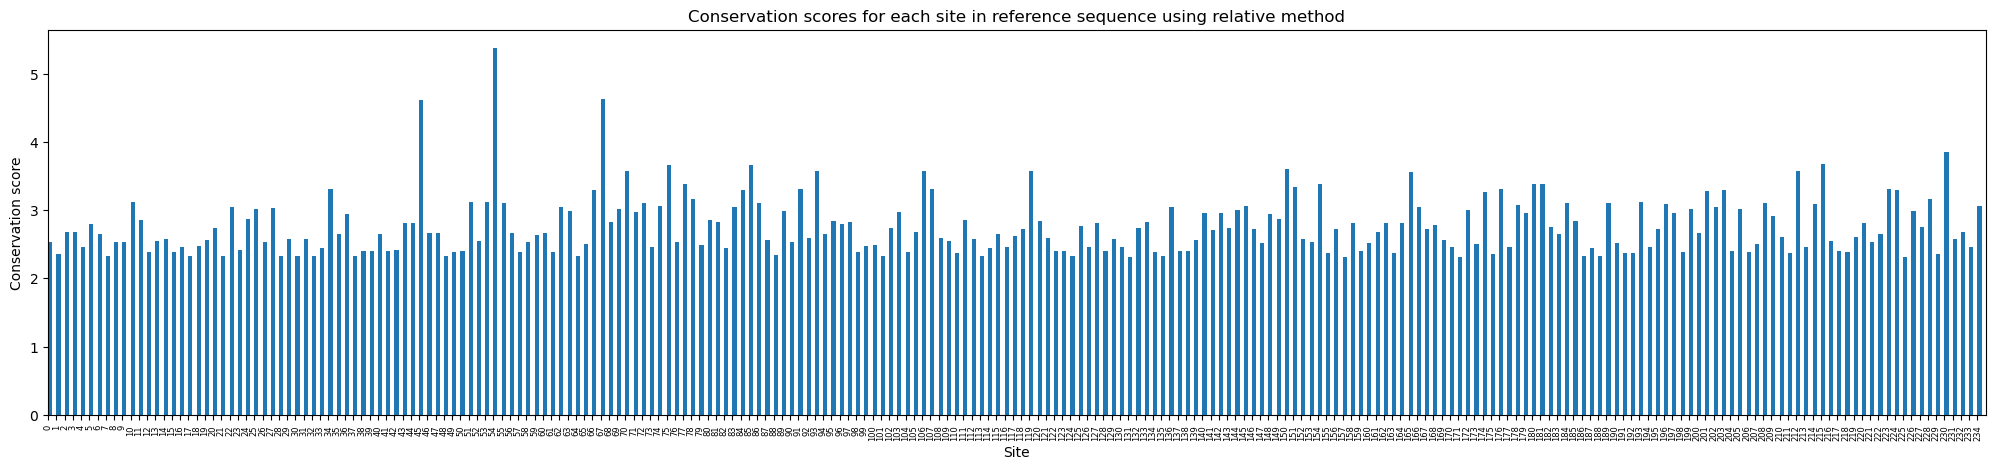

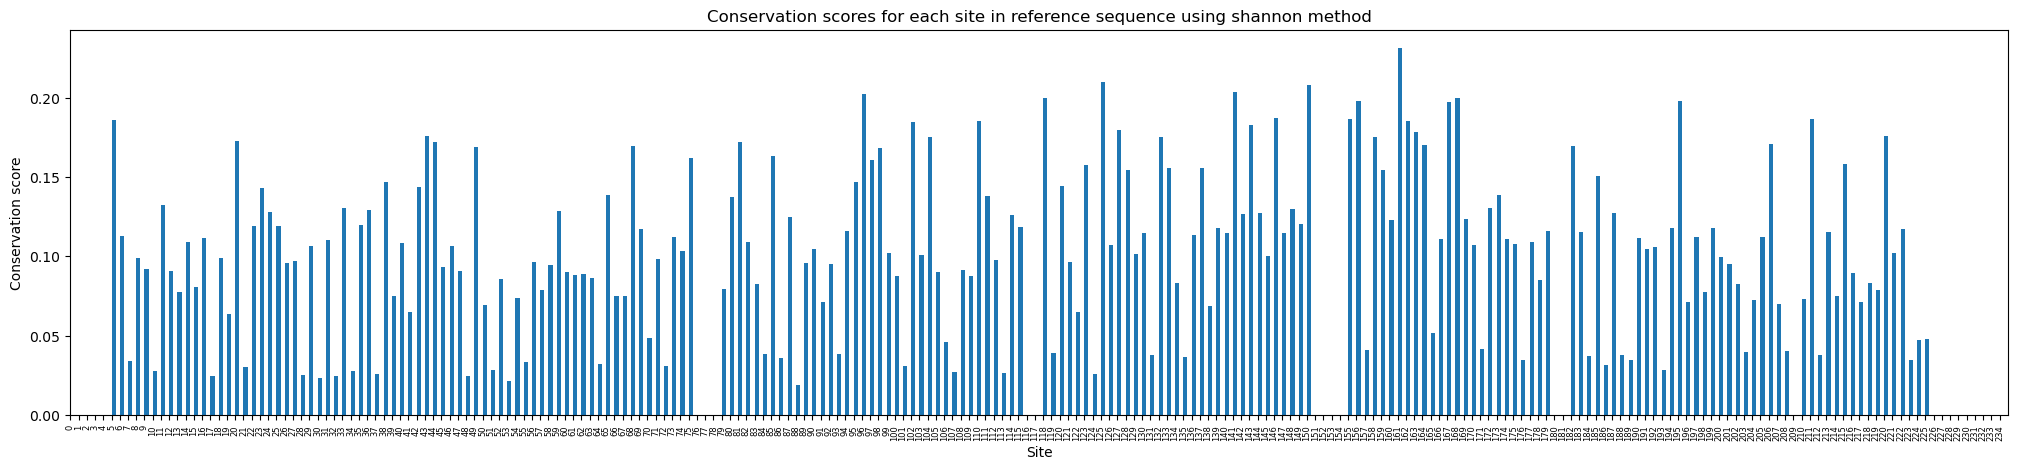

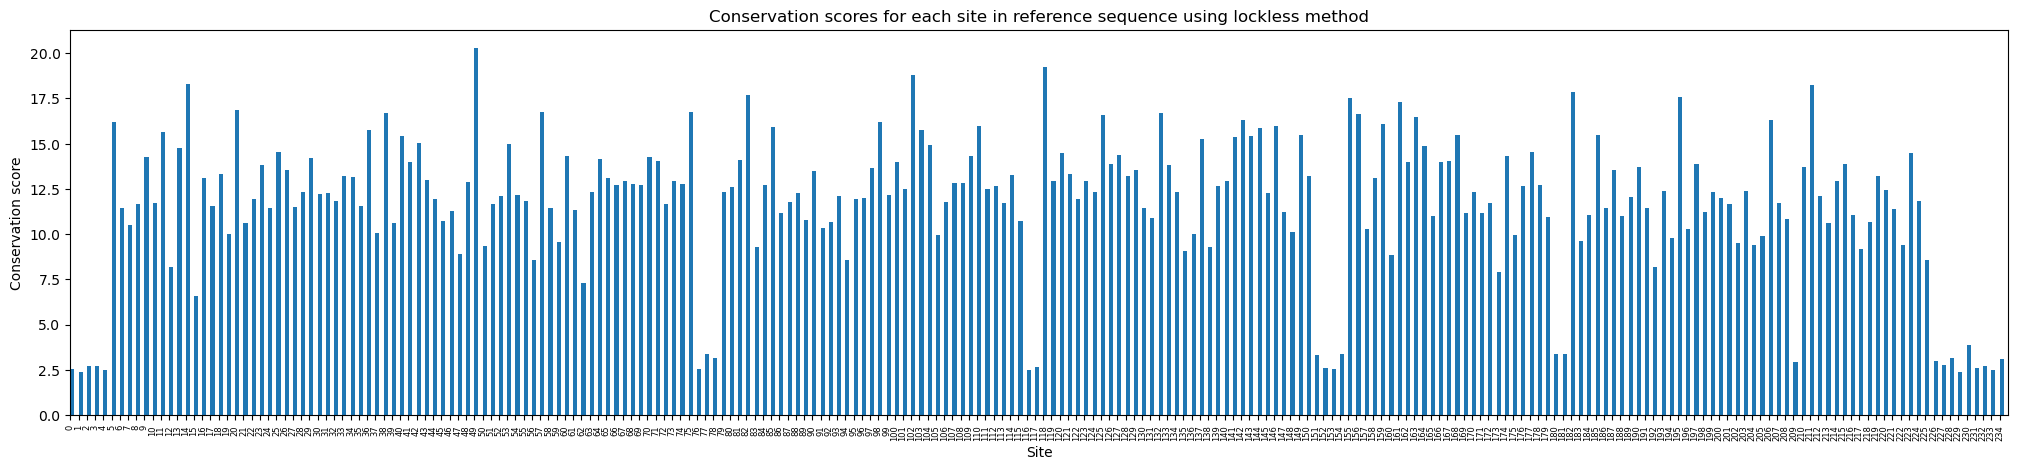

In [27]:
# Bat plot conservation scores for each site in reference sequence using matplotlib

for method in ['relative', 'shannon', 'lockless']:

    heights = cons_scores[method]
    bars = range(len(heights))
    y_pos = np.arange(len(bars))

    # Make figure wider
    plt.figure(figsize=(25, 5))

    plt.bar(y_pos, heights, align='edge', width=0.5)
    plt.xticks(y_pos, bars)

    plt.title(f'Conservation scores for each site in reference sequence using {method} method')
    plt.xlabel('Site')
    plt.ylabel('Conservation score')

    plt.xticks(rotation=90, fontsize=6)
    plt.xlim(0, len(heights))

    plt.show()


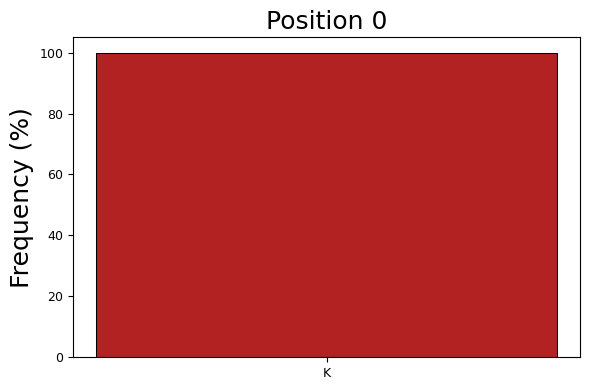

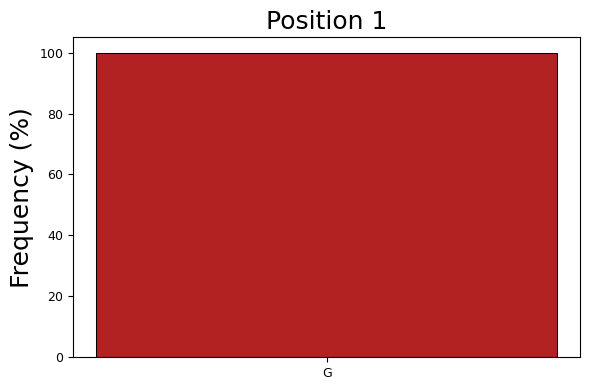

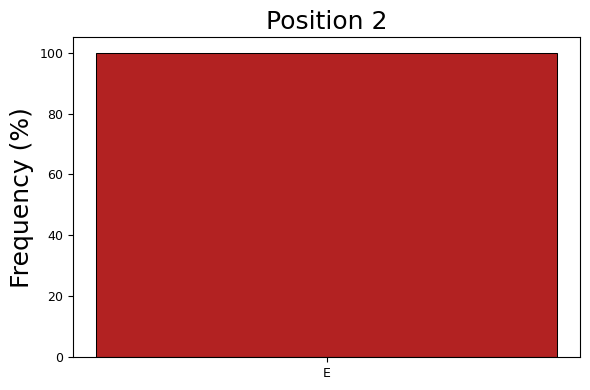

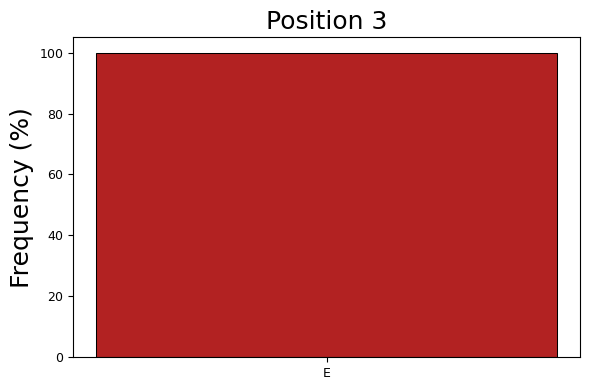

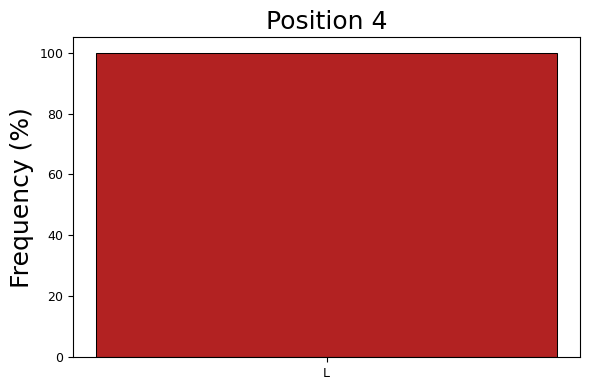

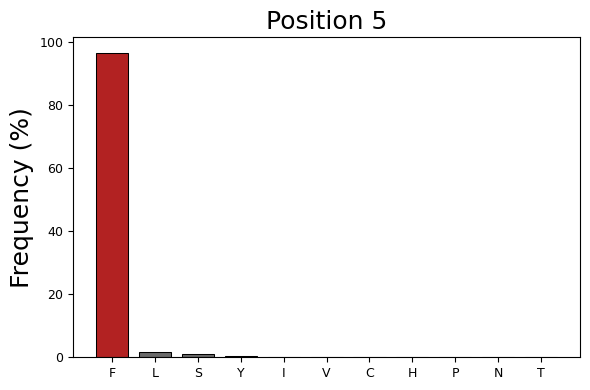

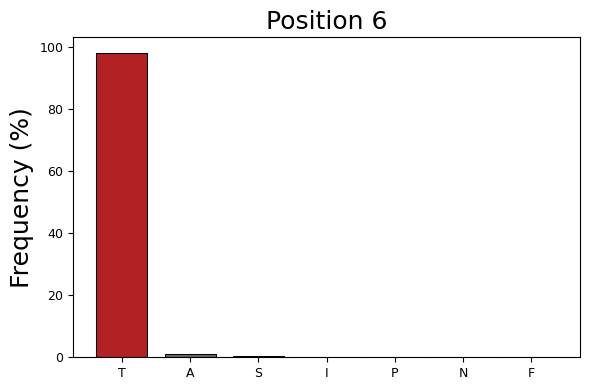

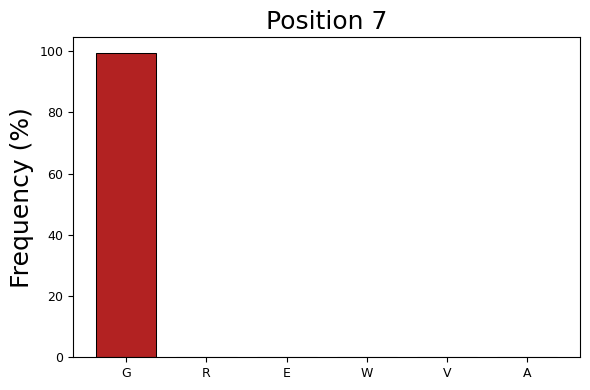

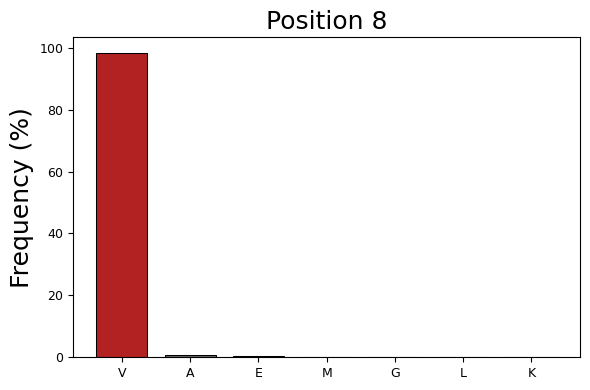

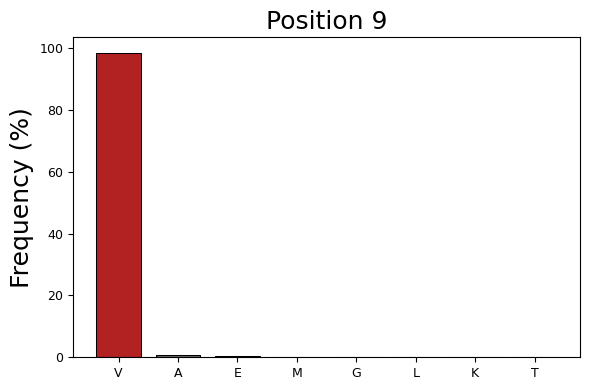

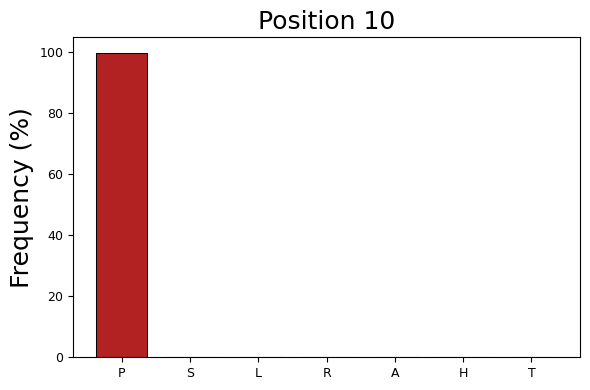

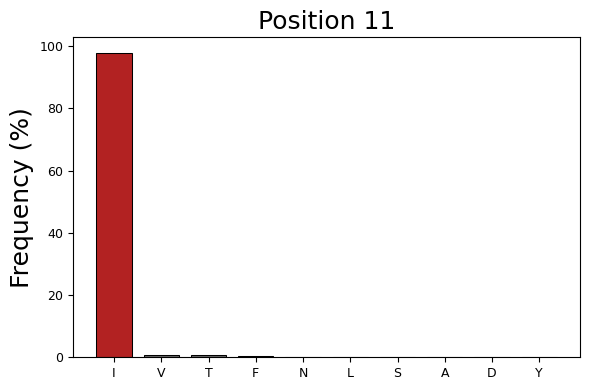

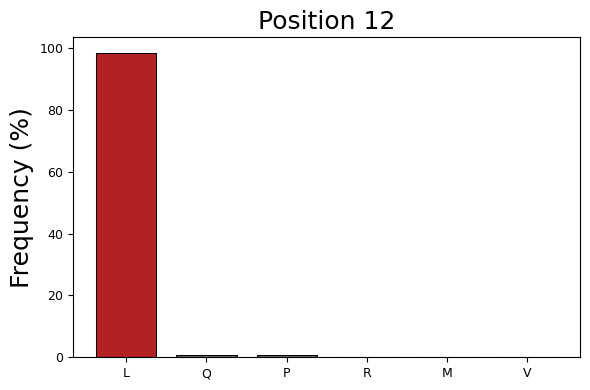

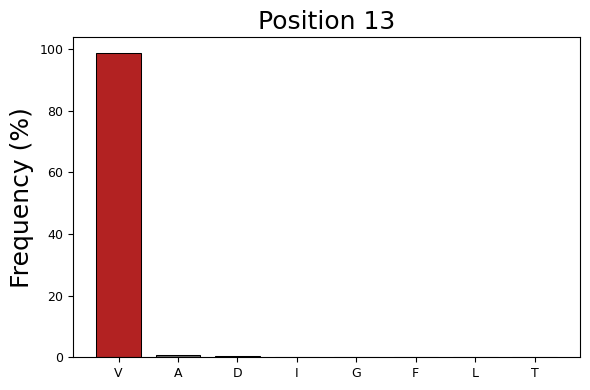

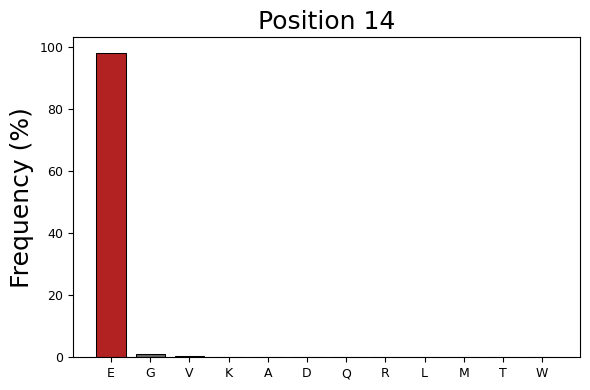

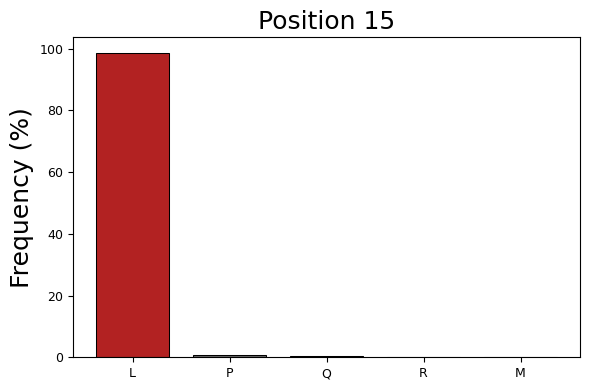

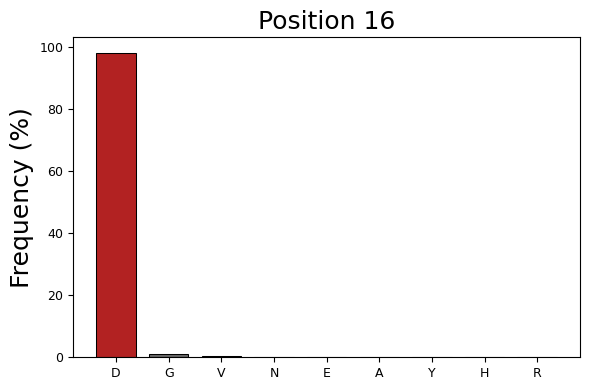

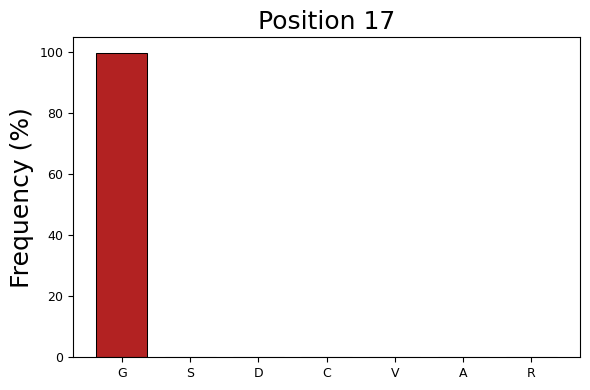

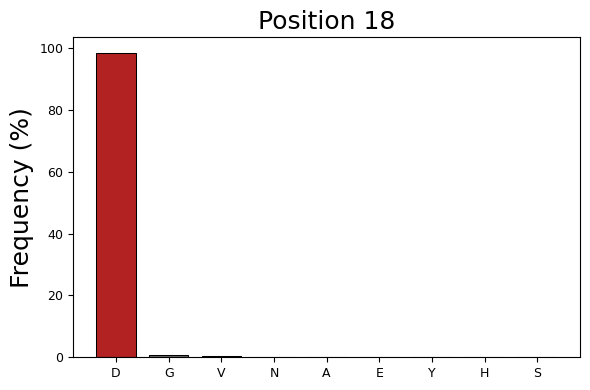

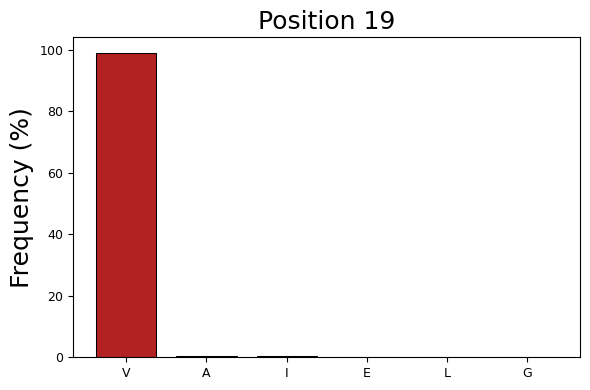

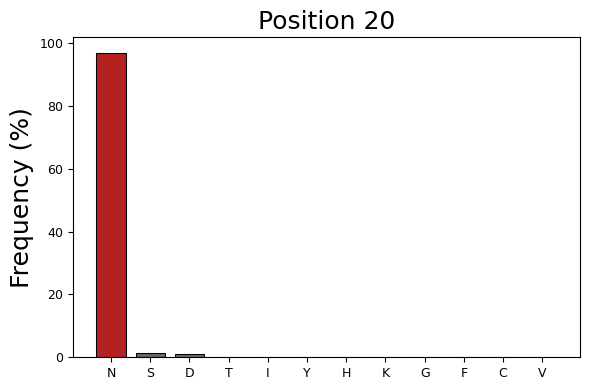

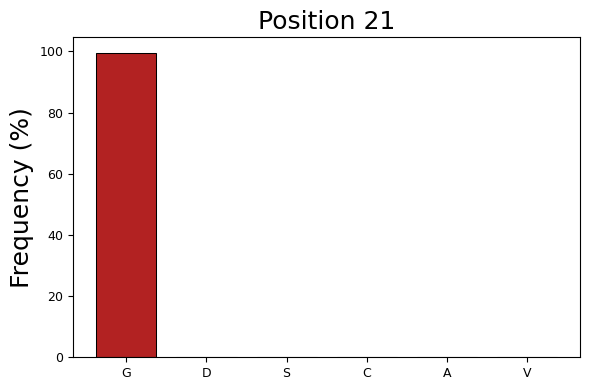

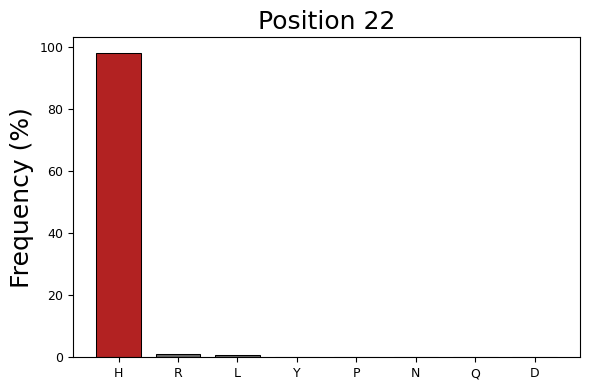

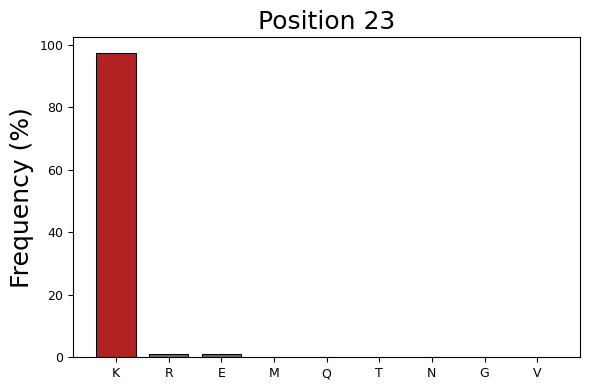

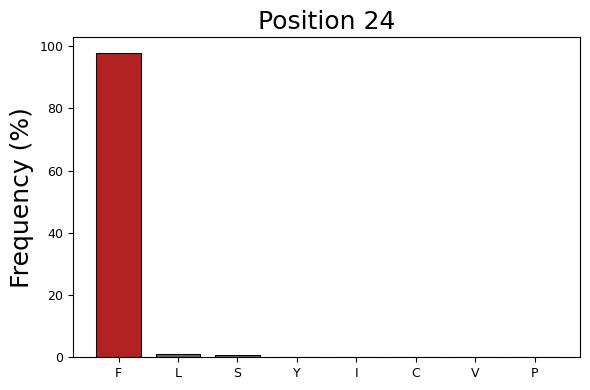

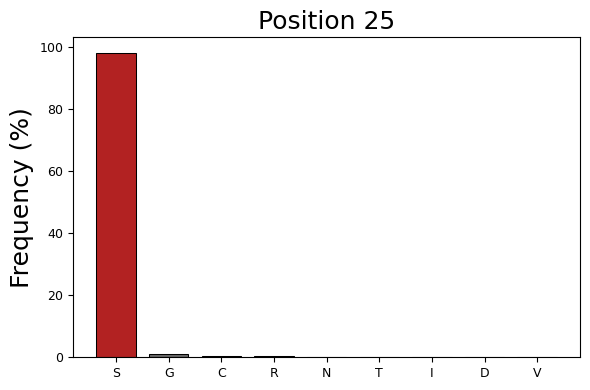

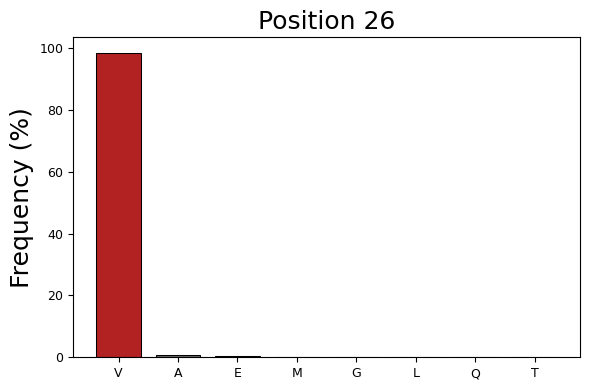

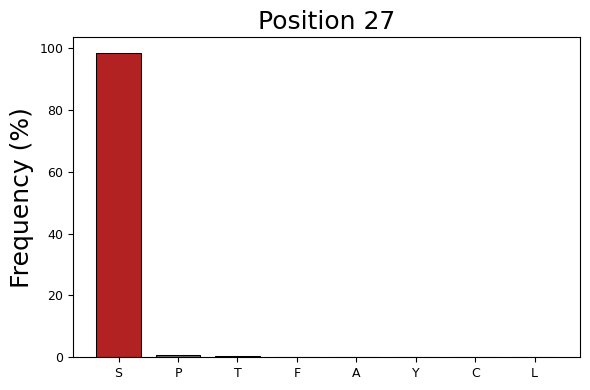

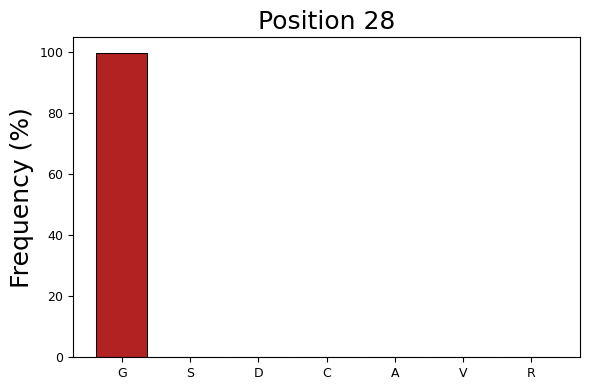

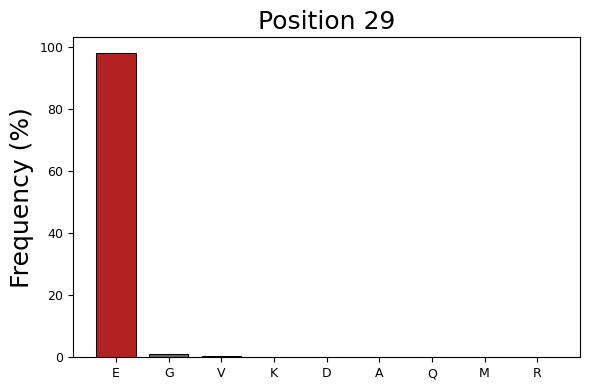

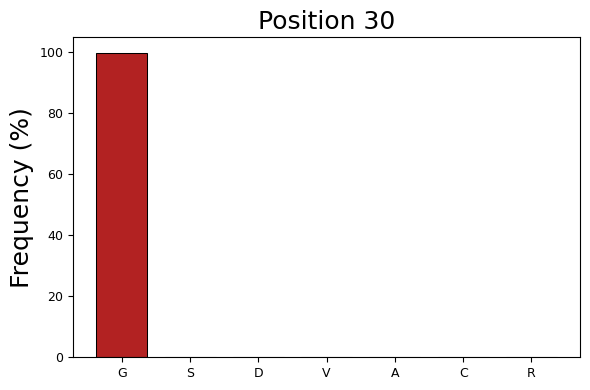

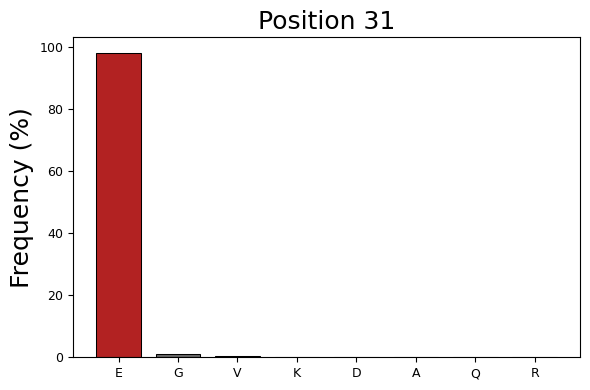

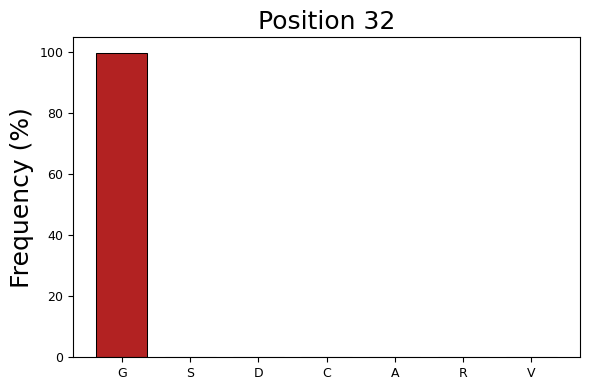

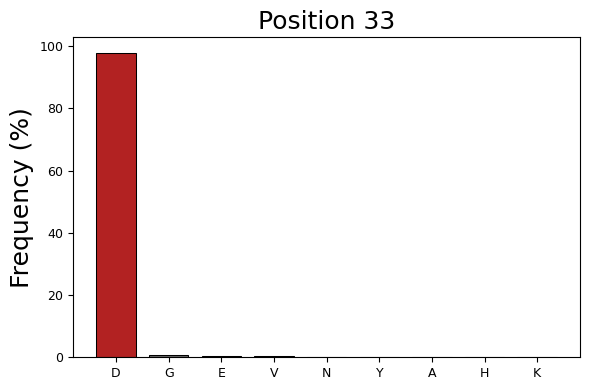

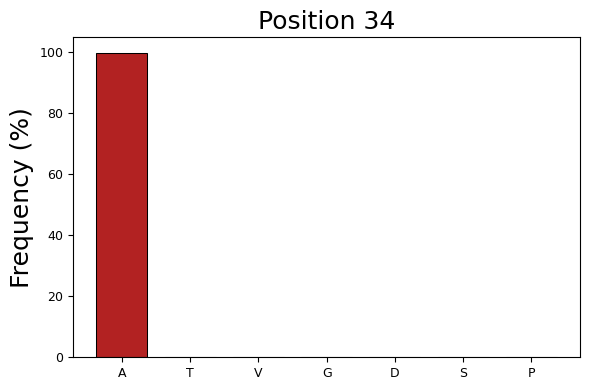

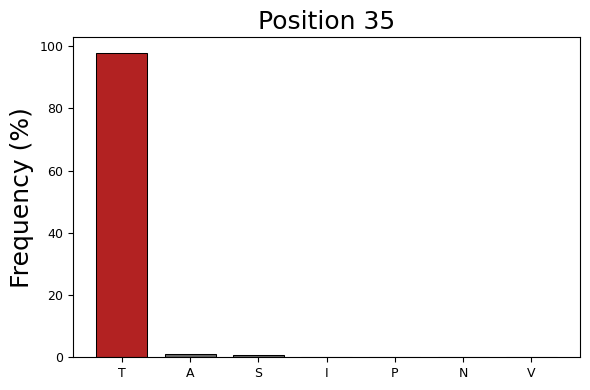

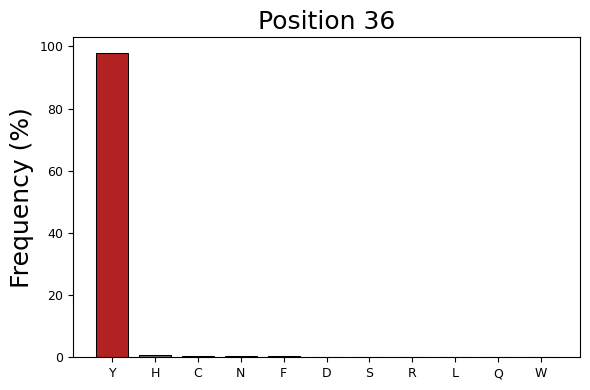

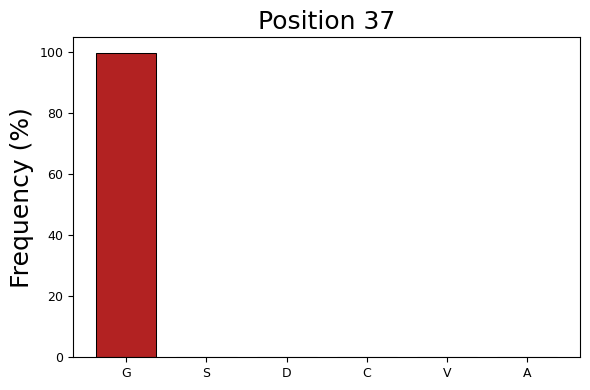

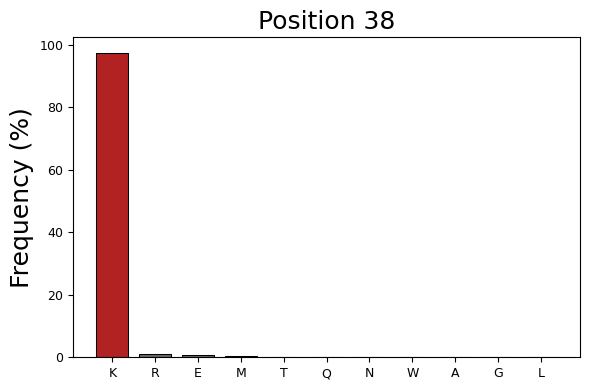

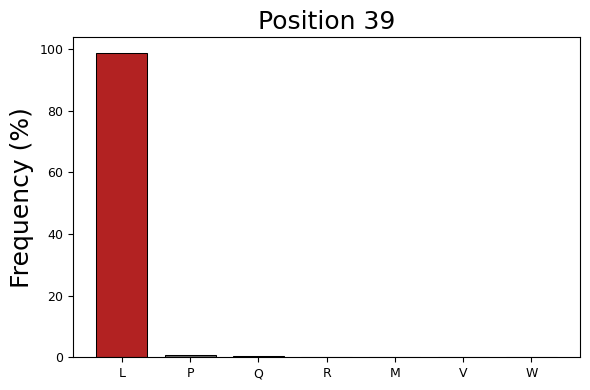

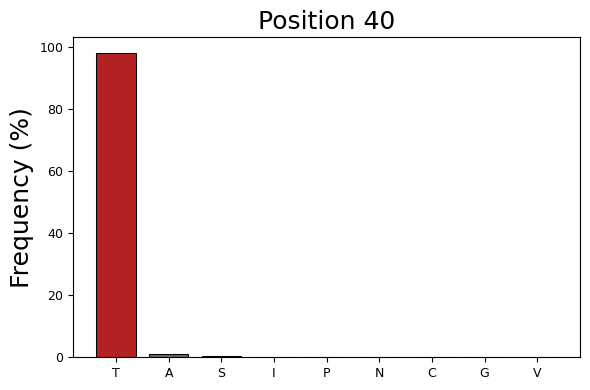

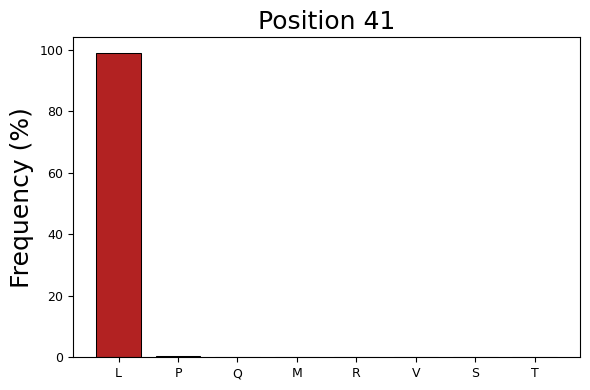

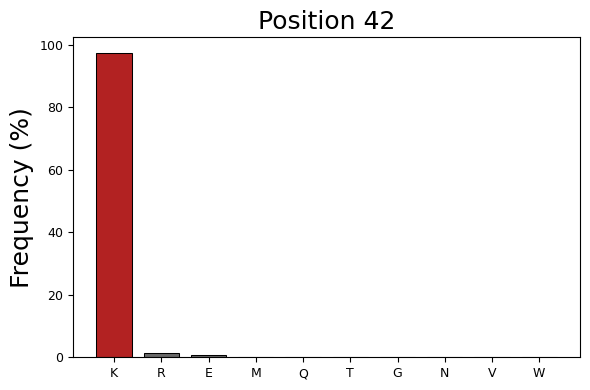

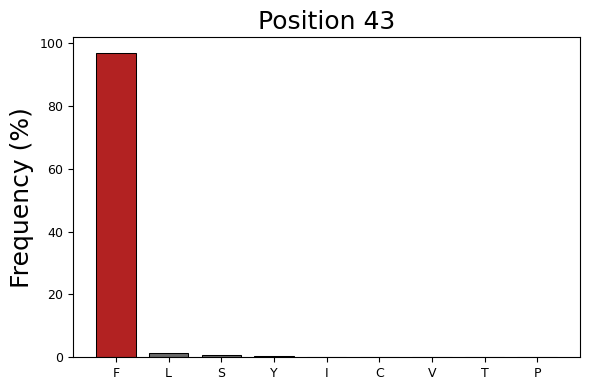

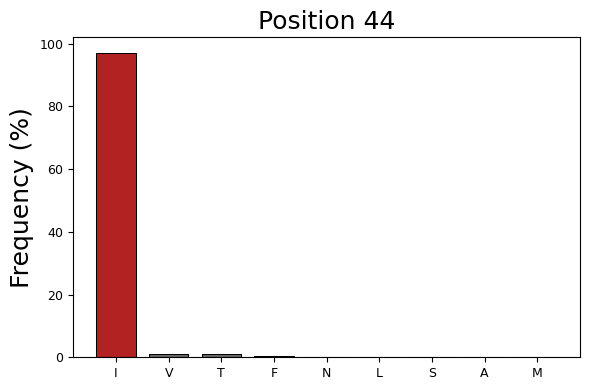

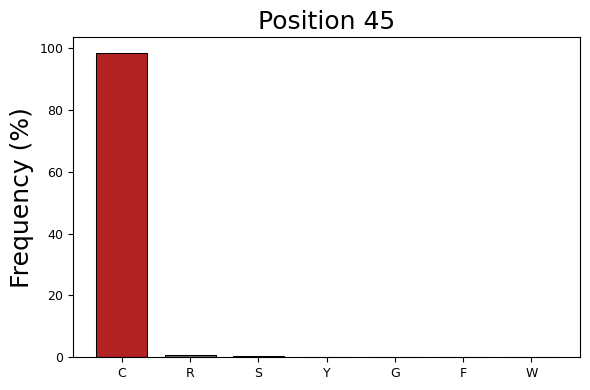

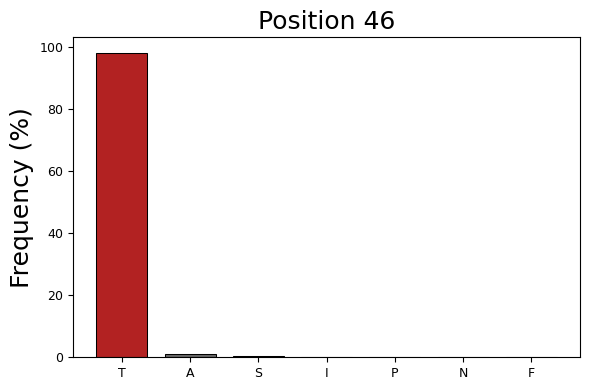

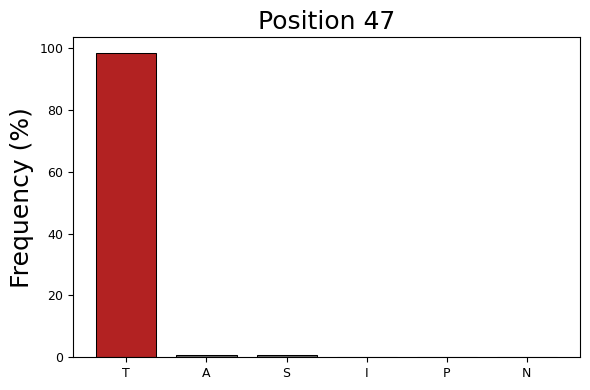

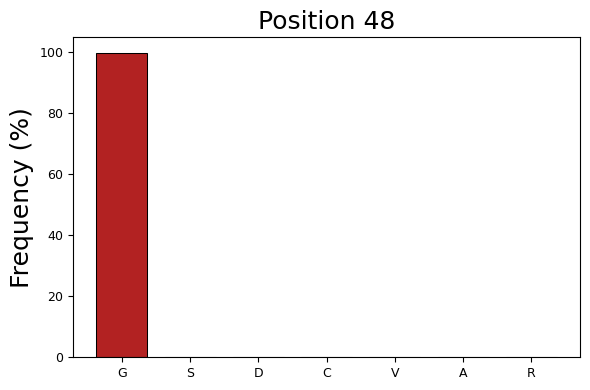

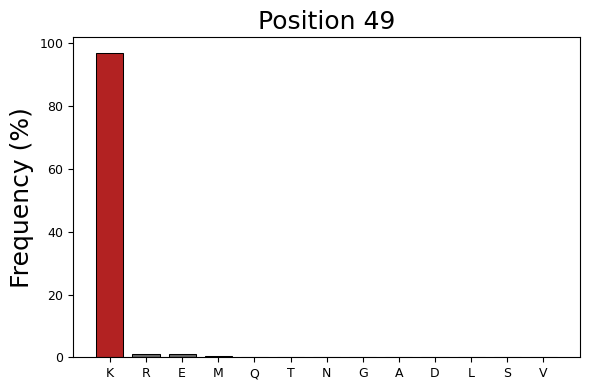

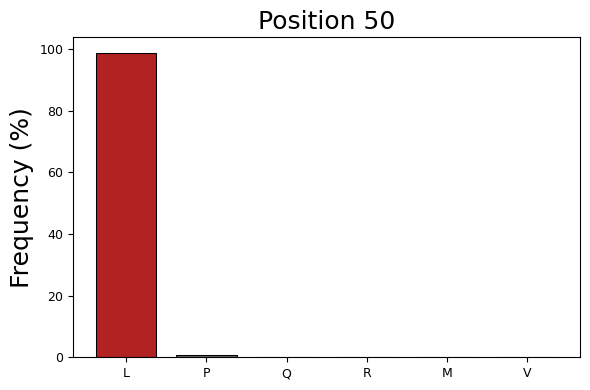

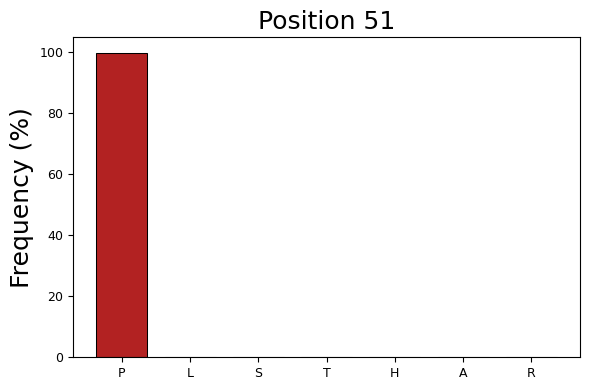

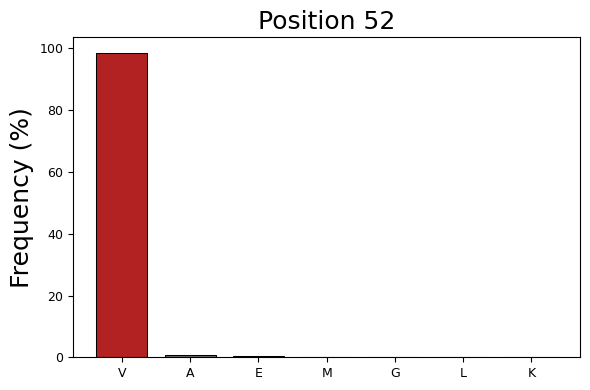

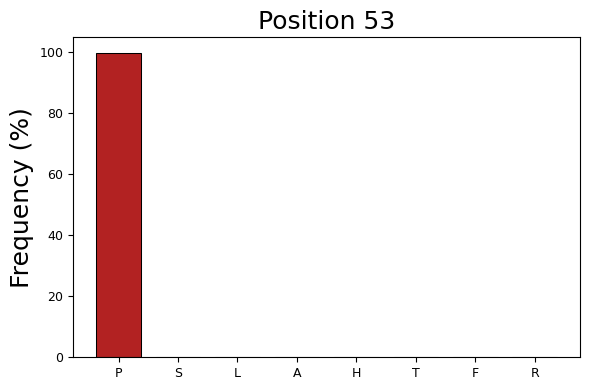

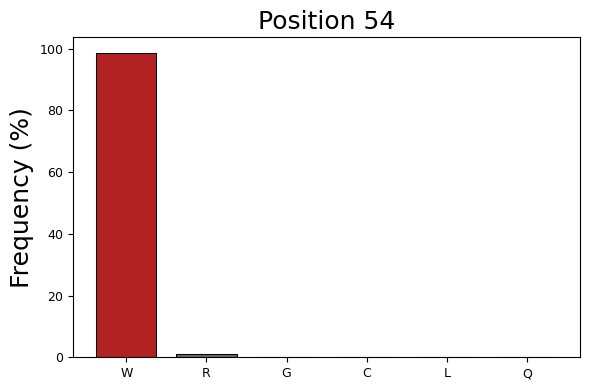

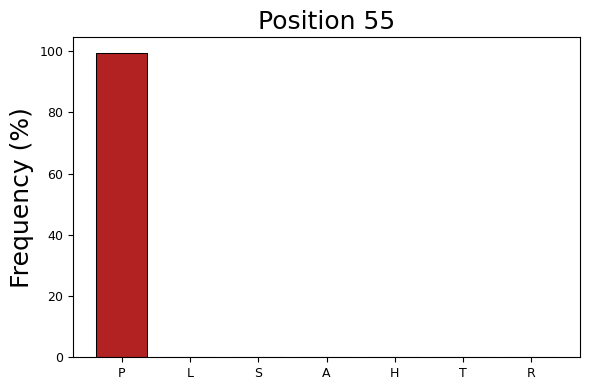

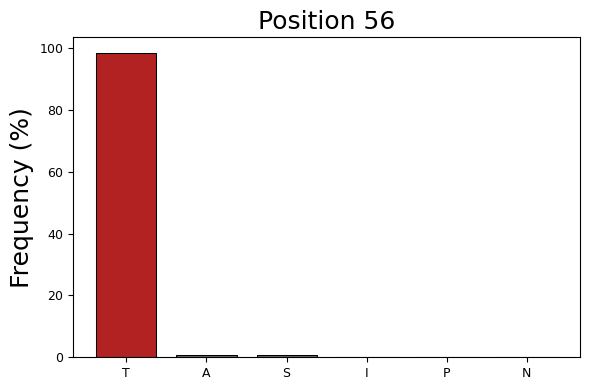

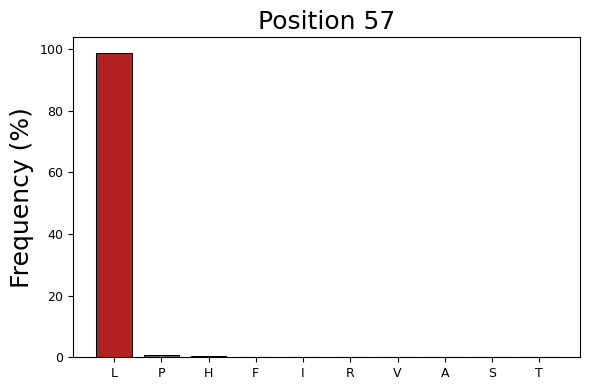

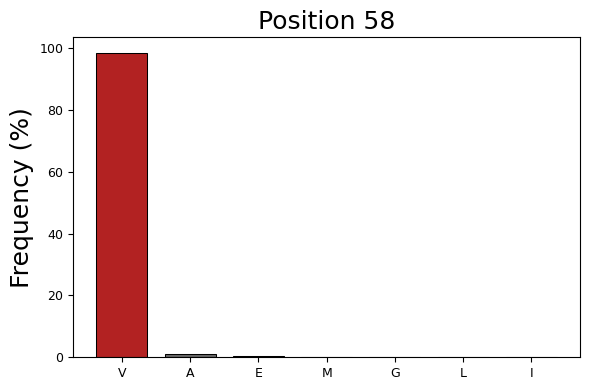

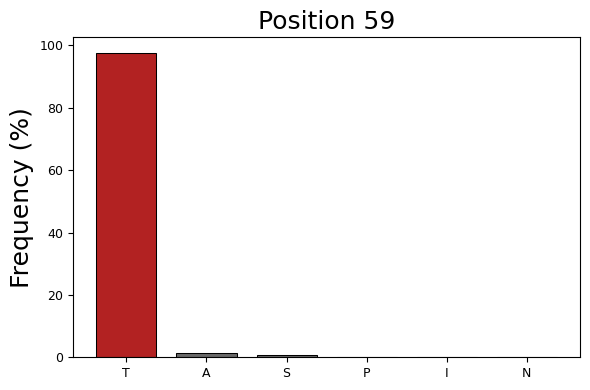

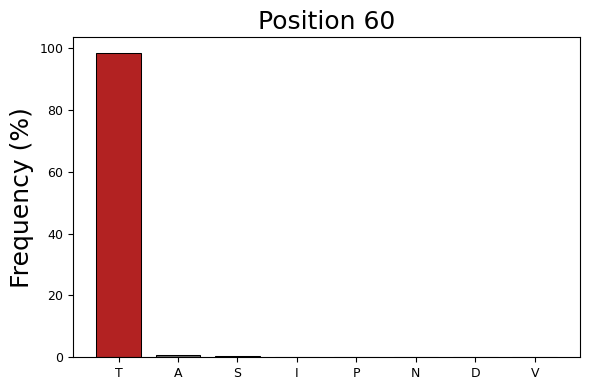

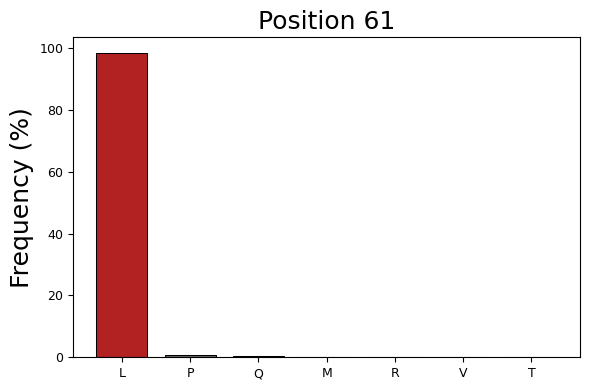

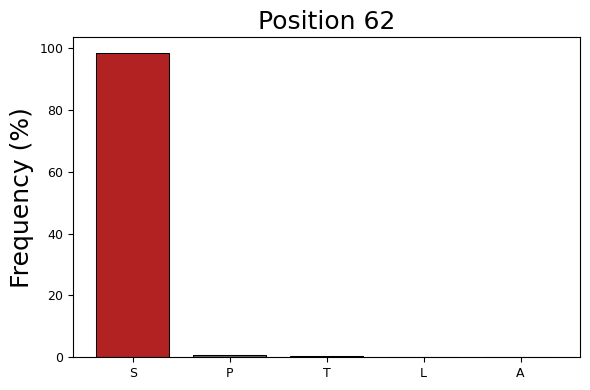

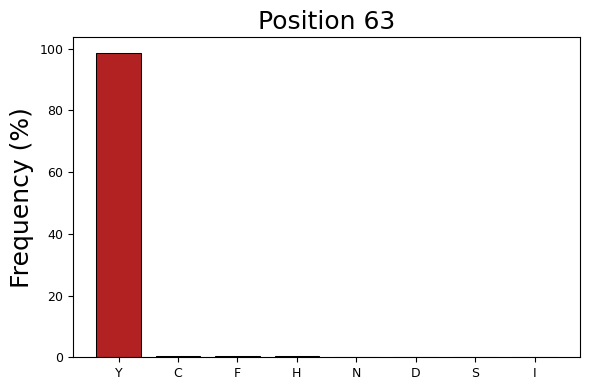

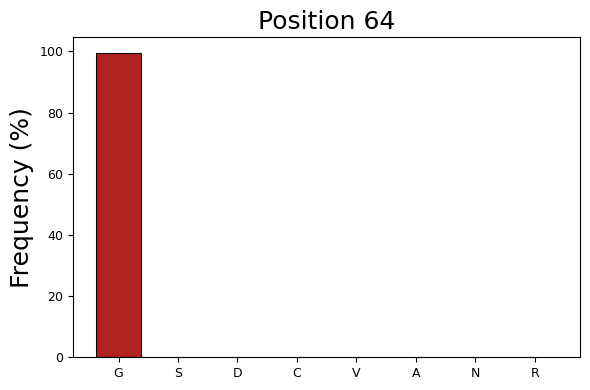

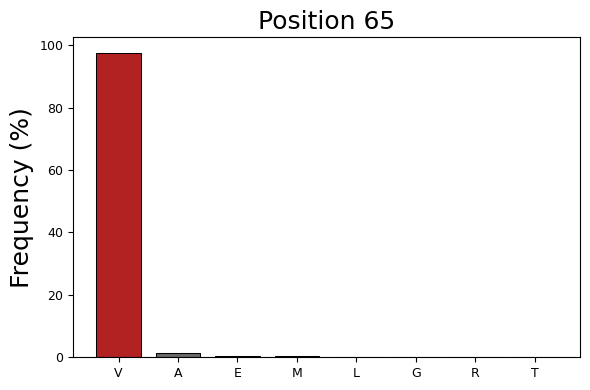

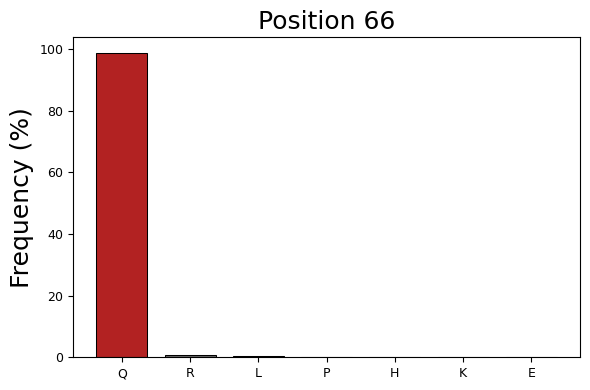

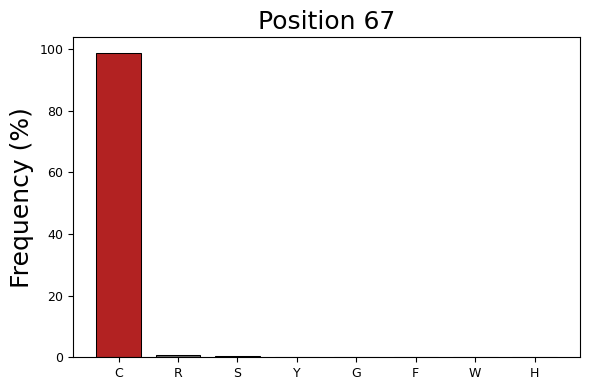

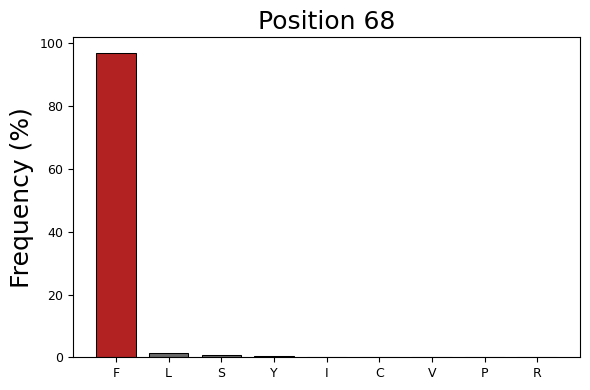

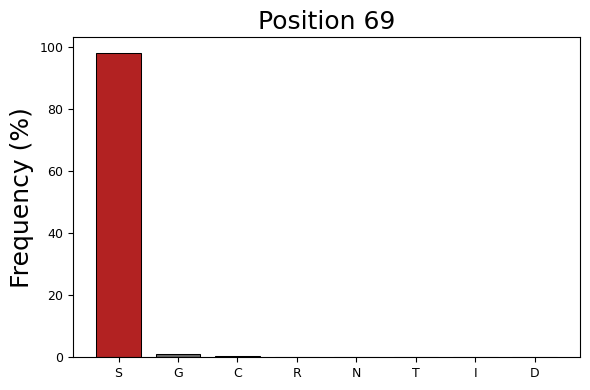

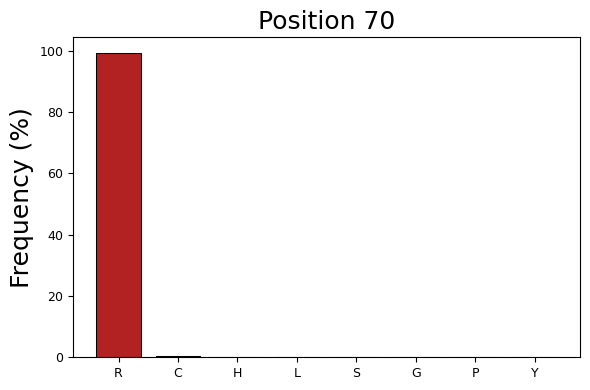

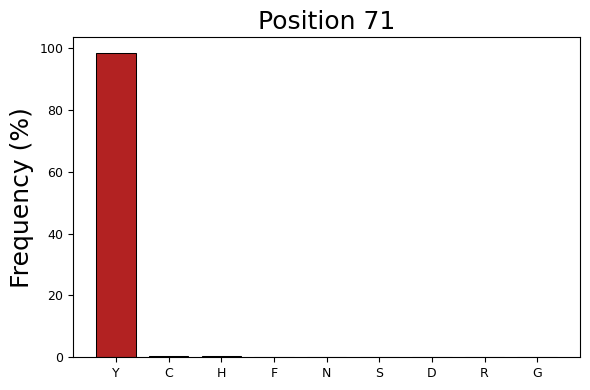

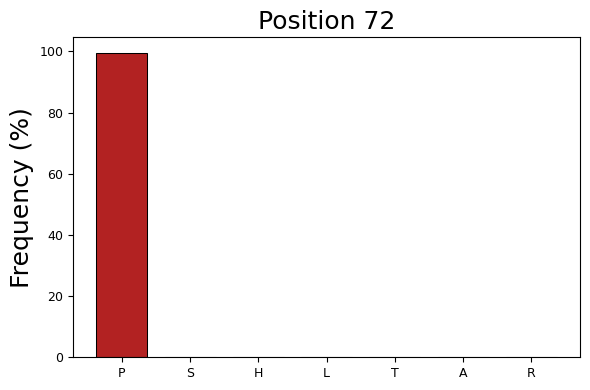

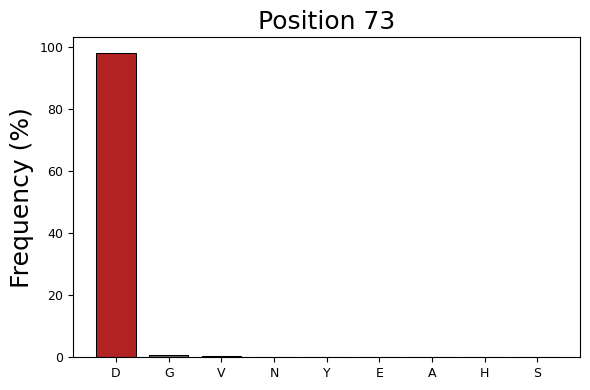

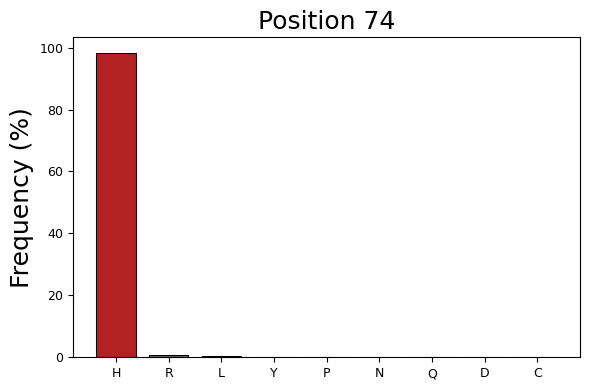

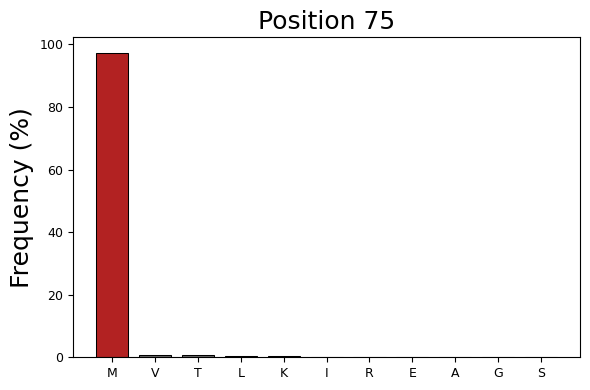

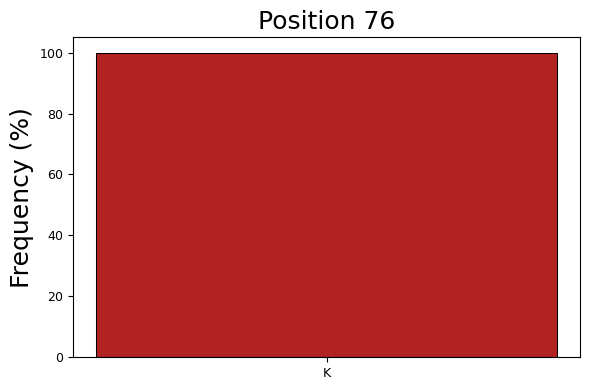

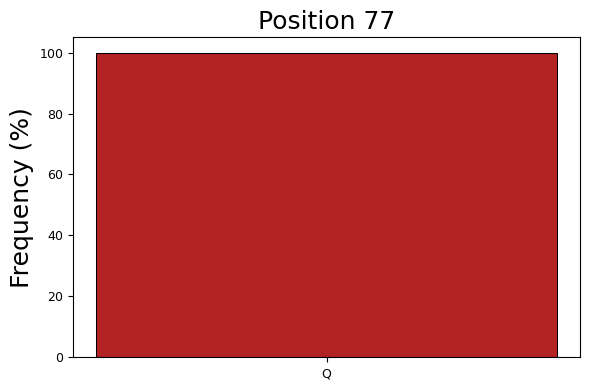

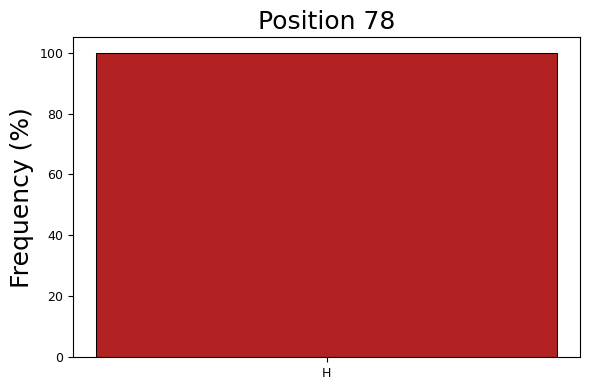

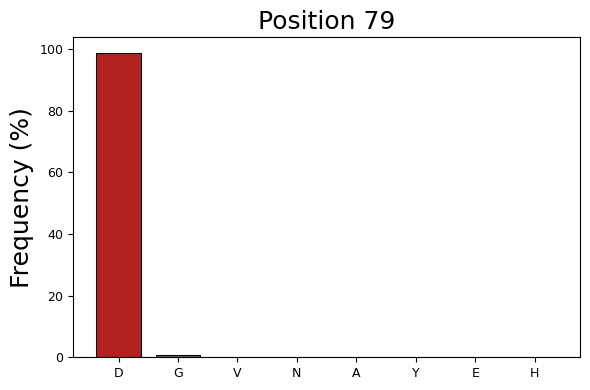

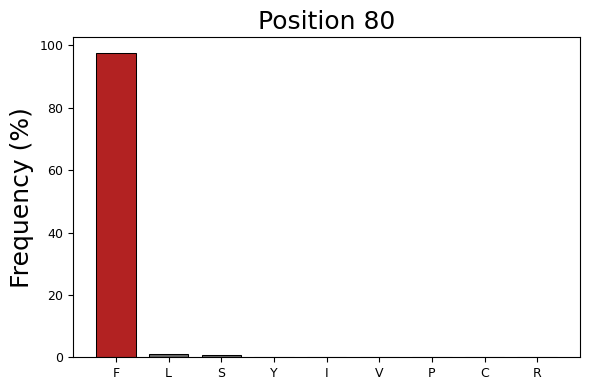

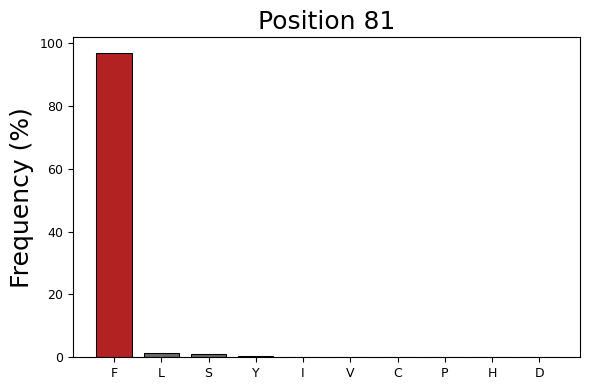

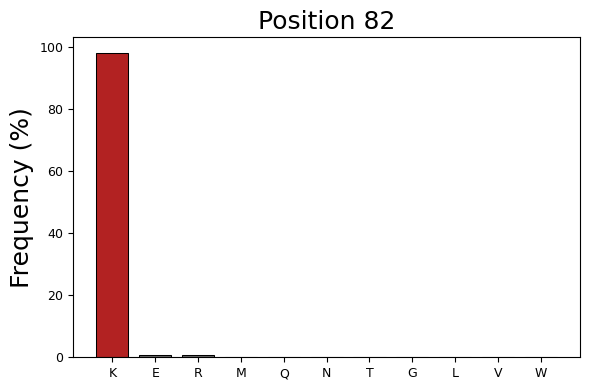

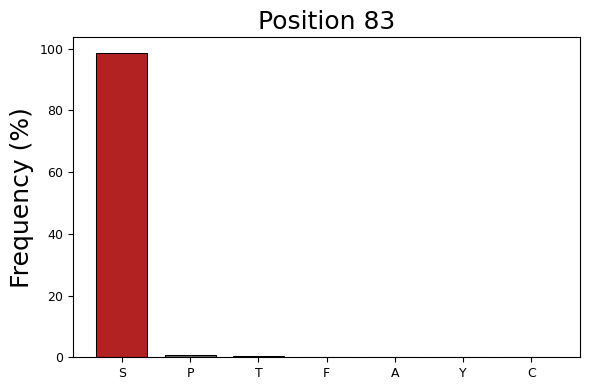

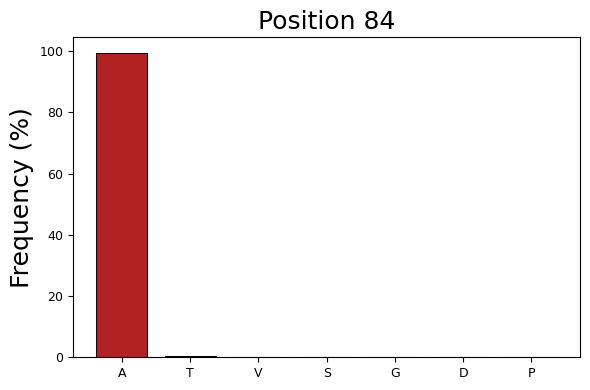

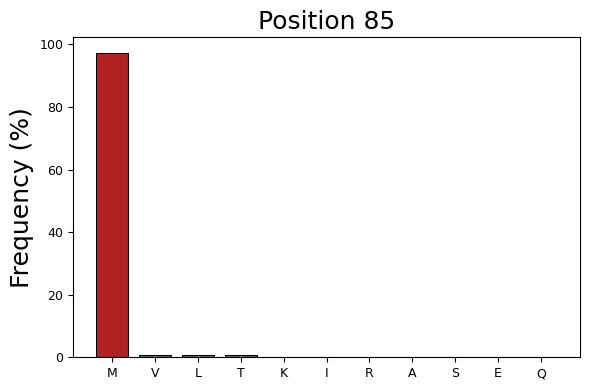

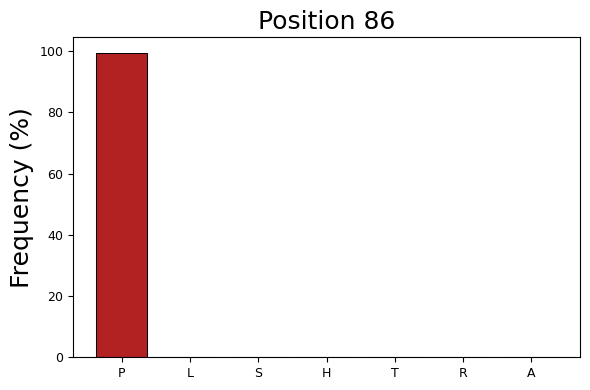

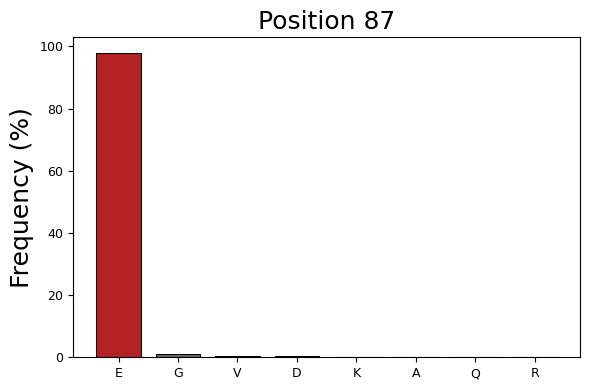

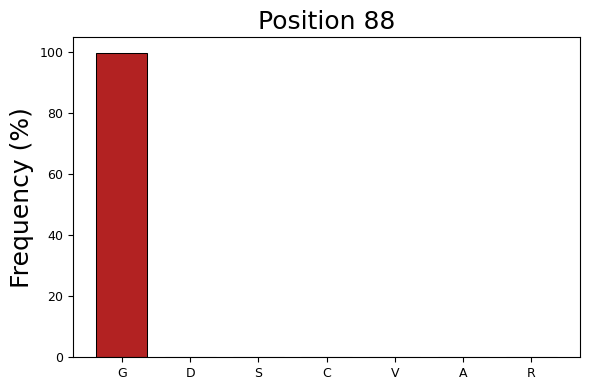

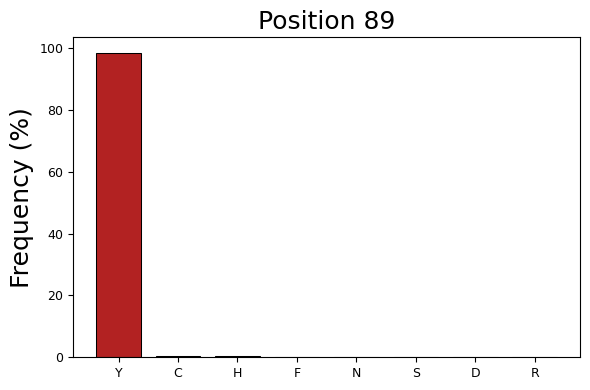

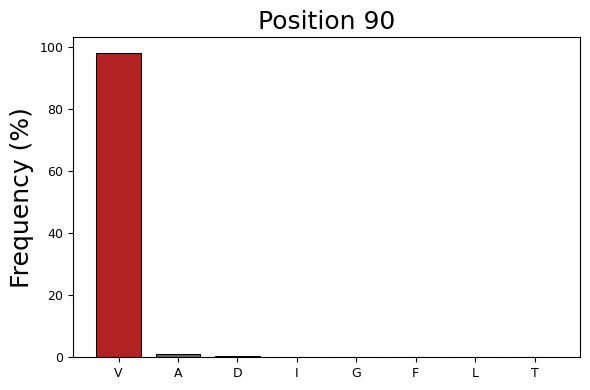

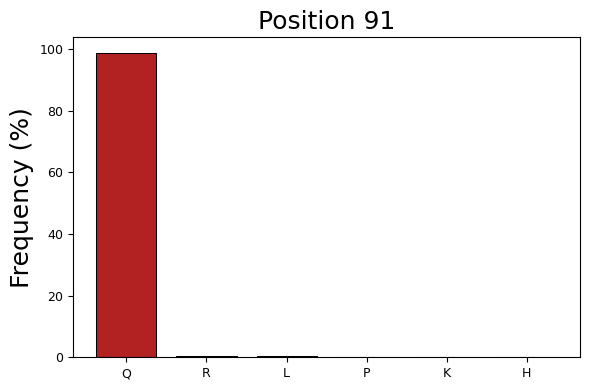

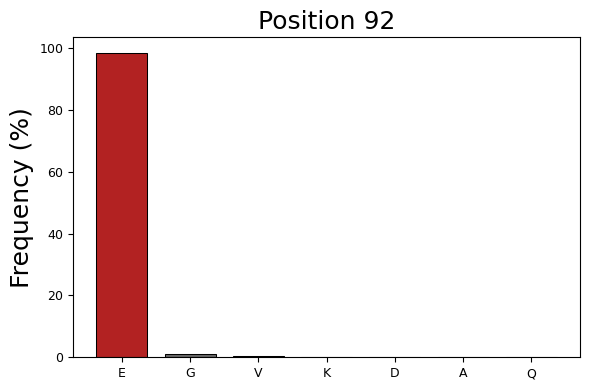

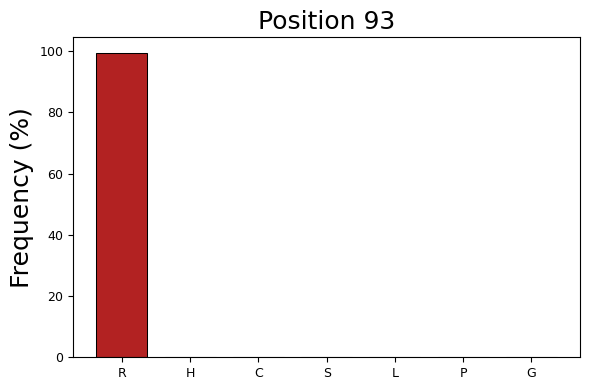

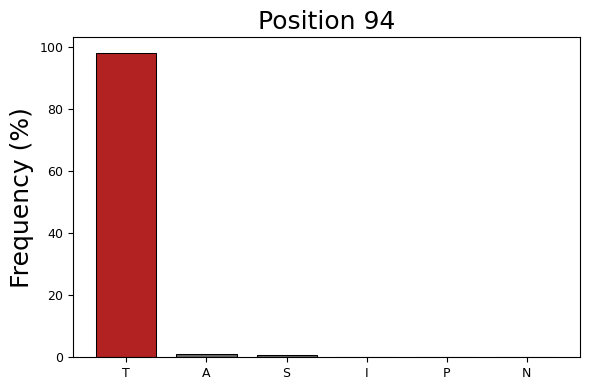

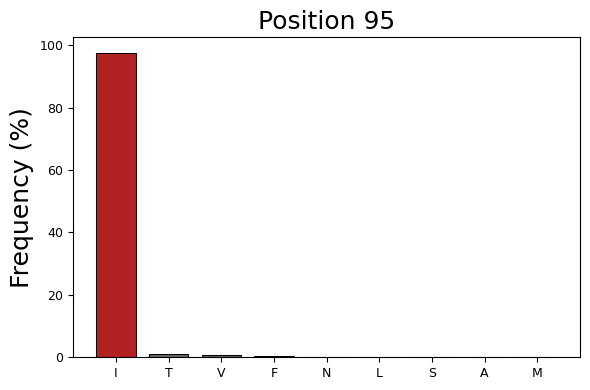

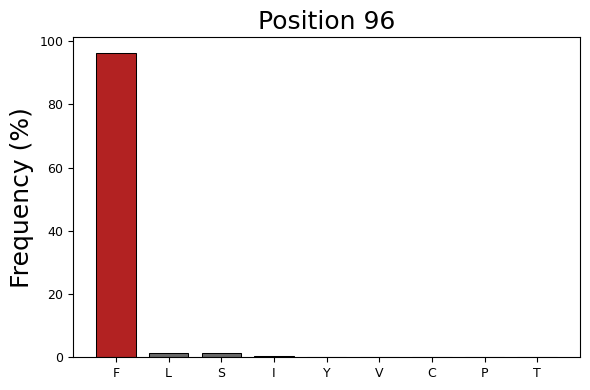

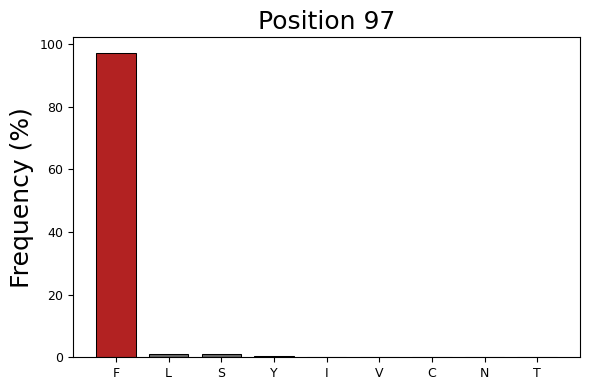

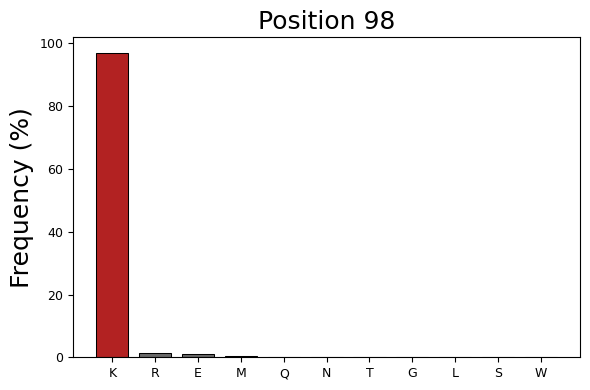

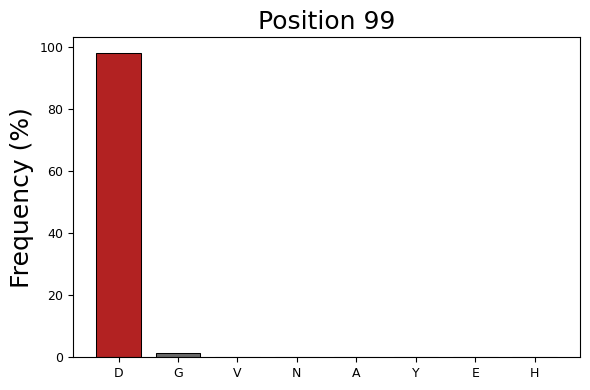

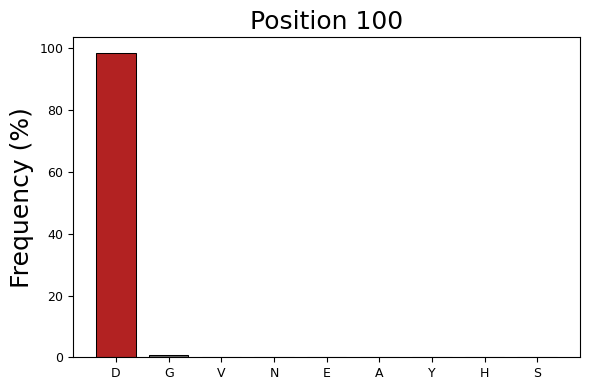

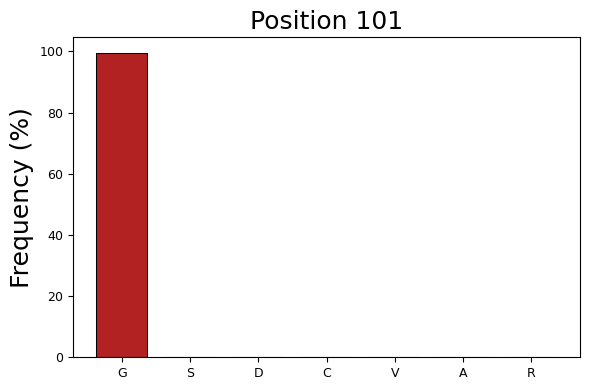

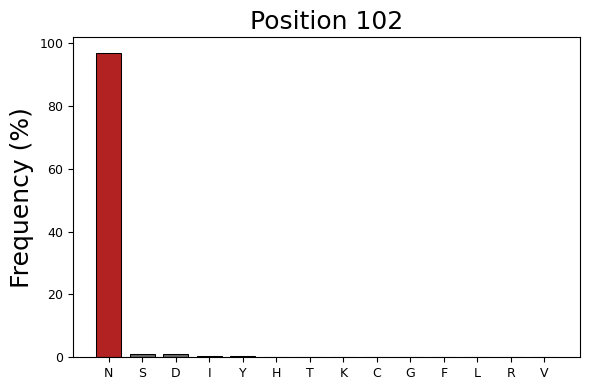

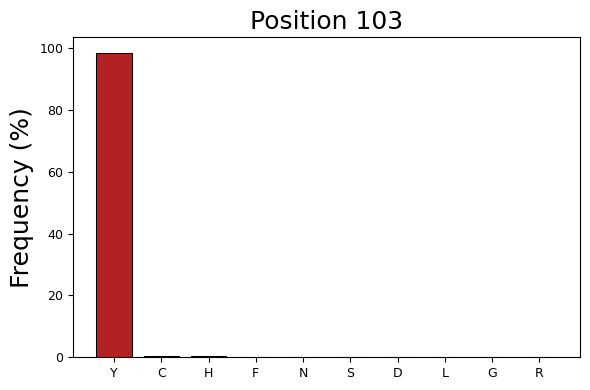

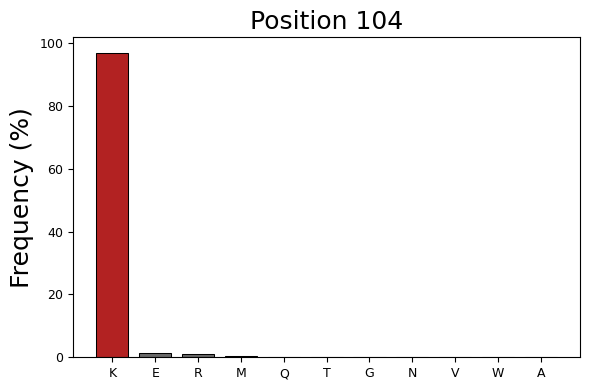

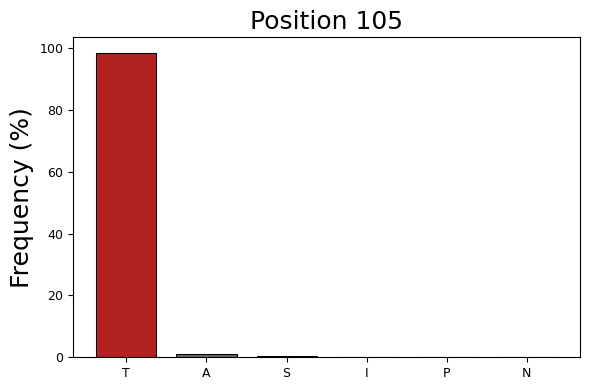

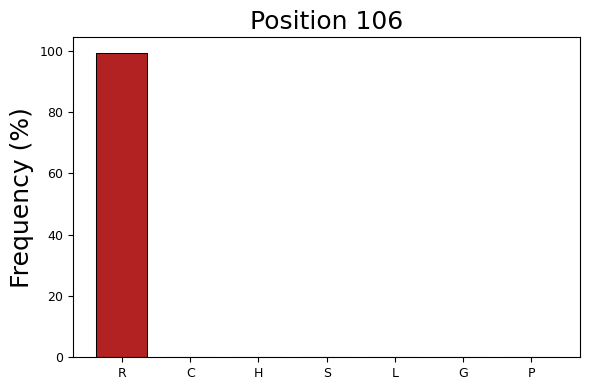

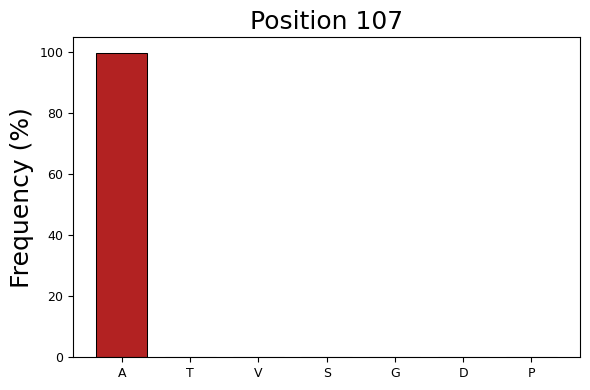

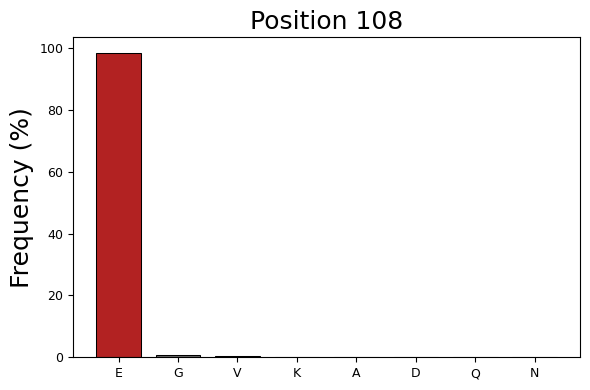

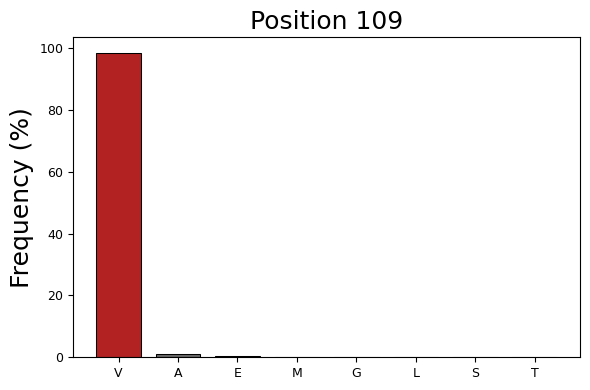

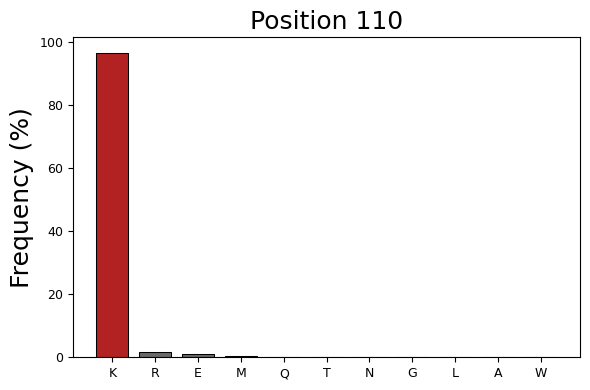

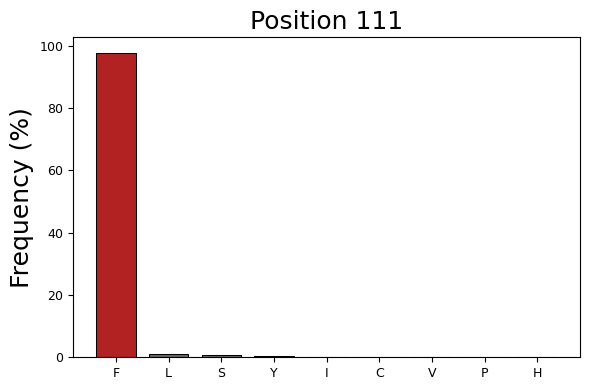

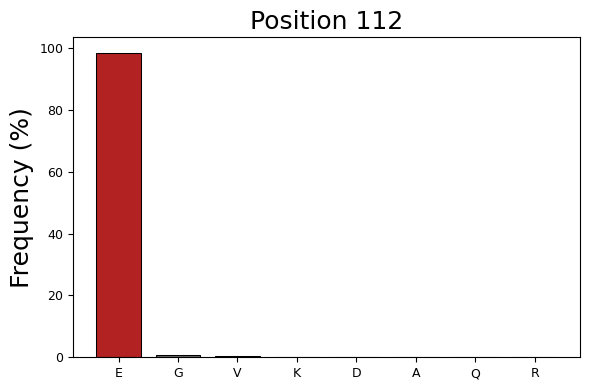

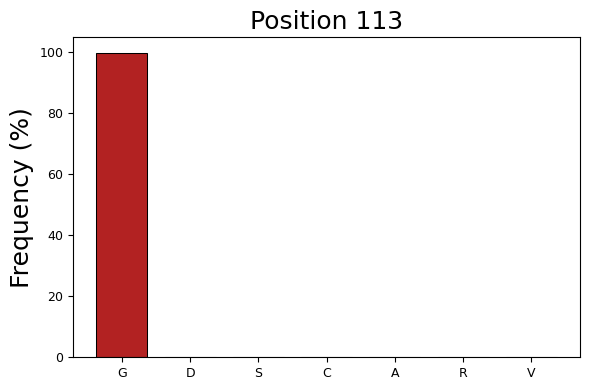

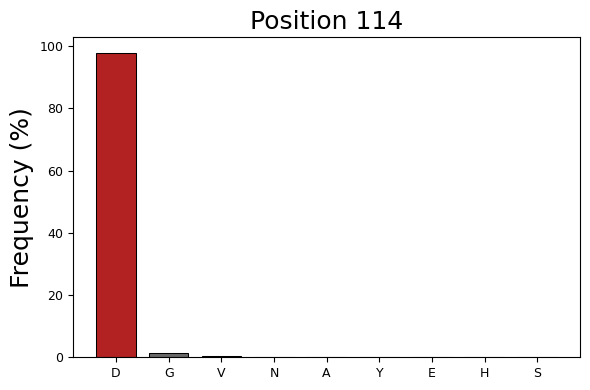

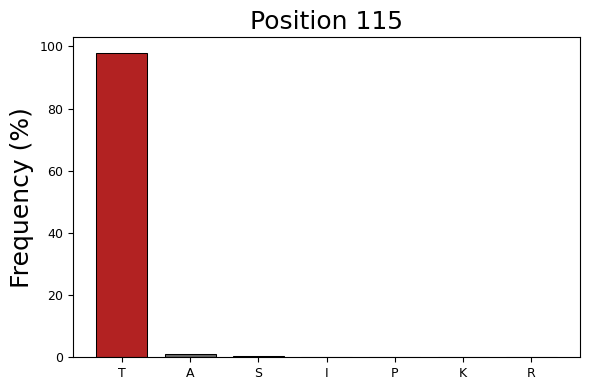

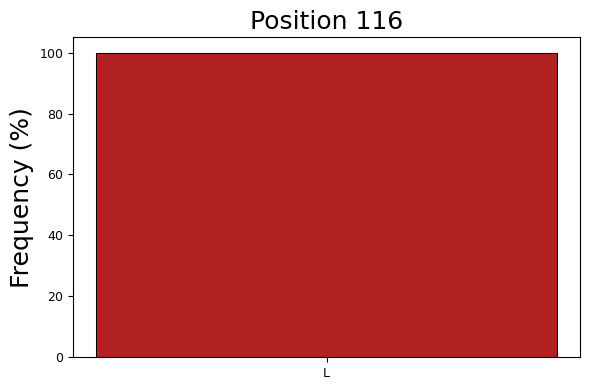

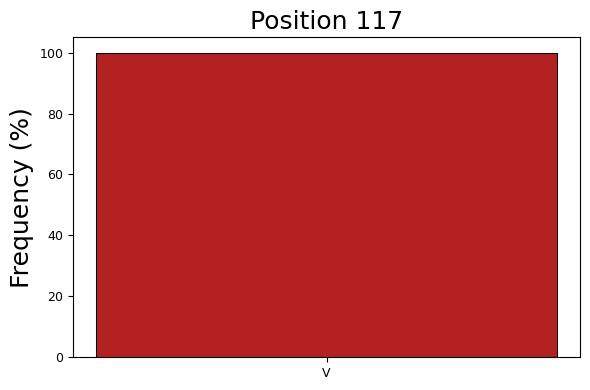

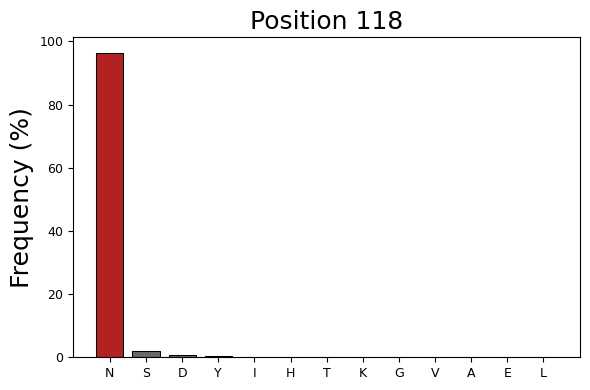

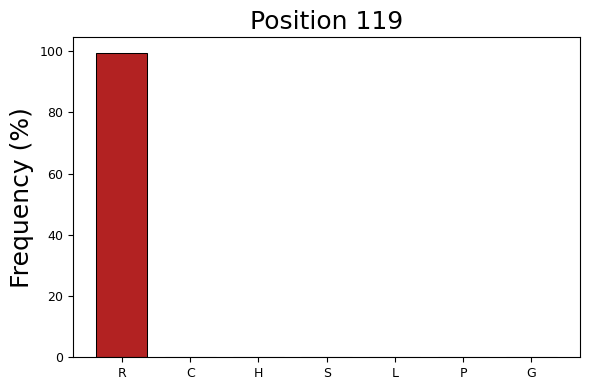

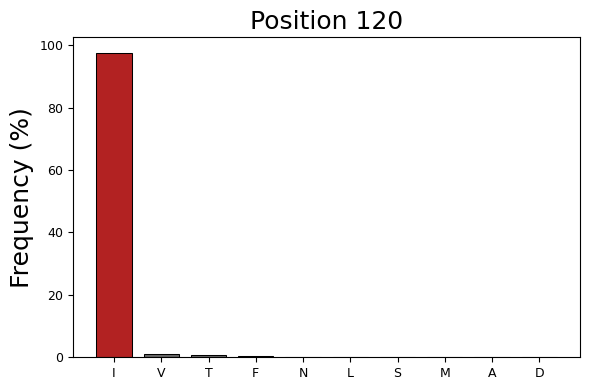

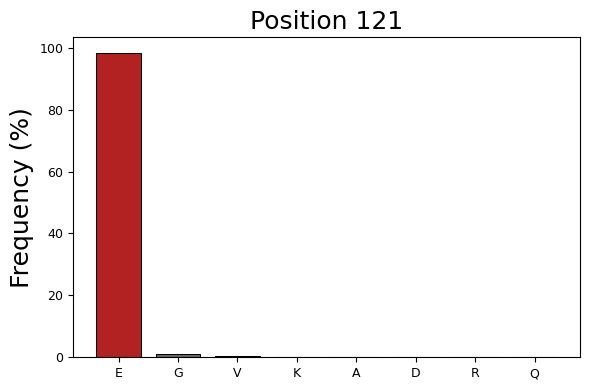

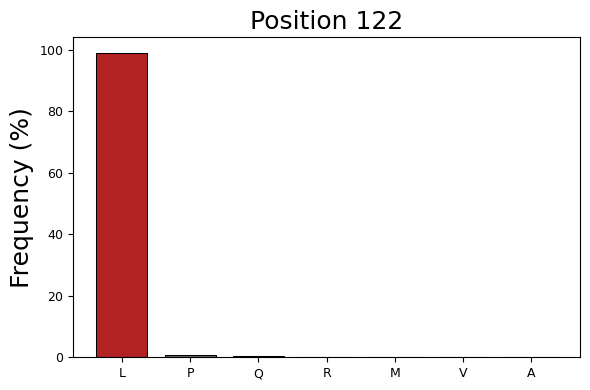

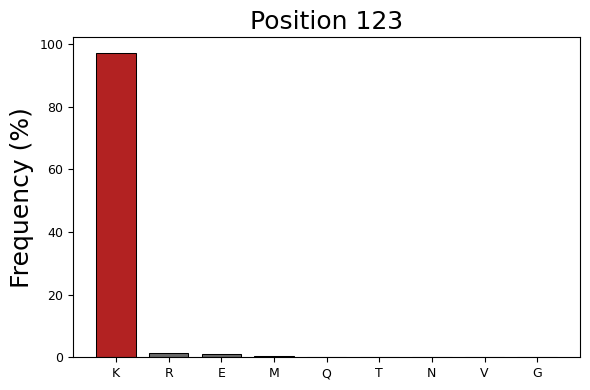

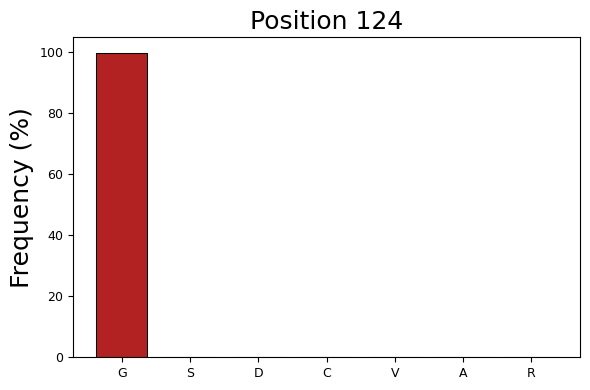

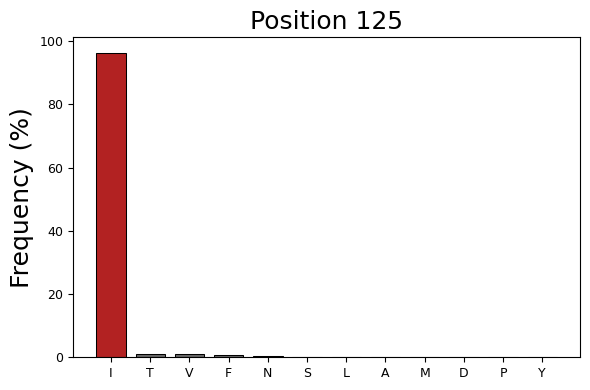

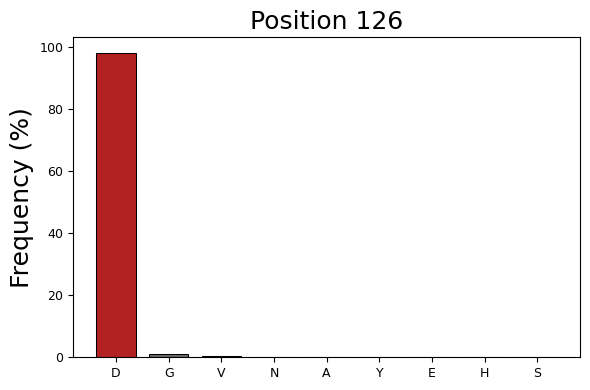

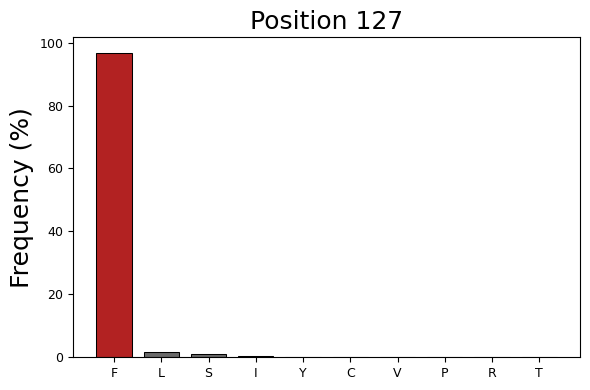

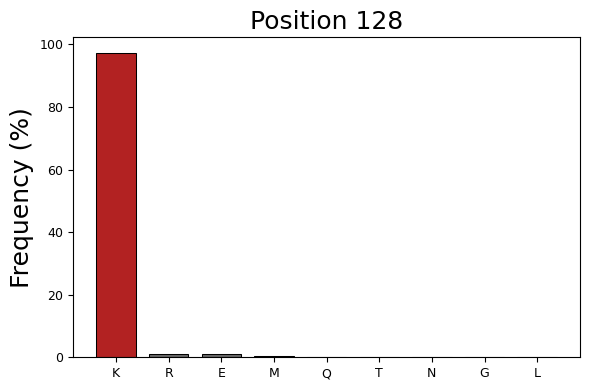

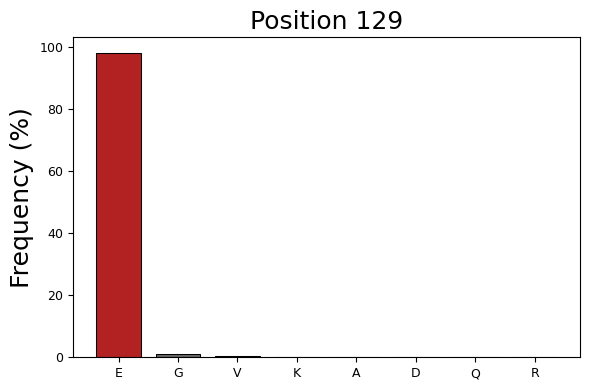

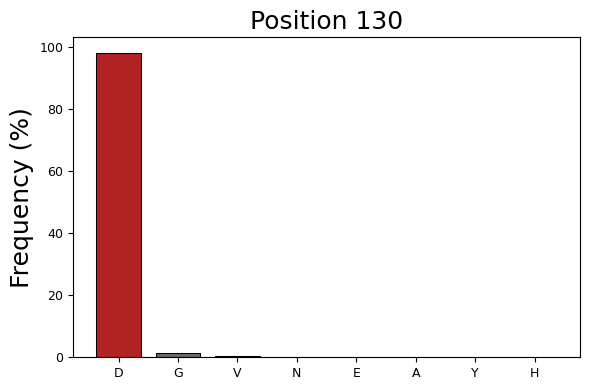

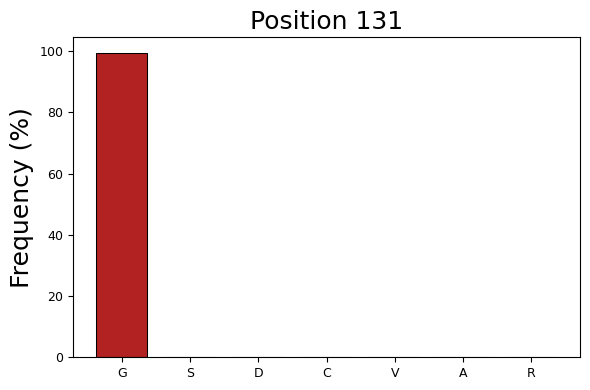

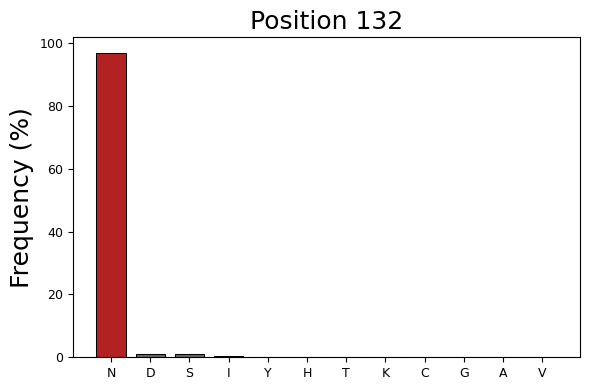

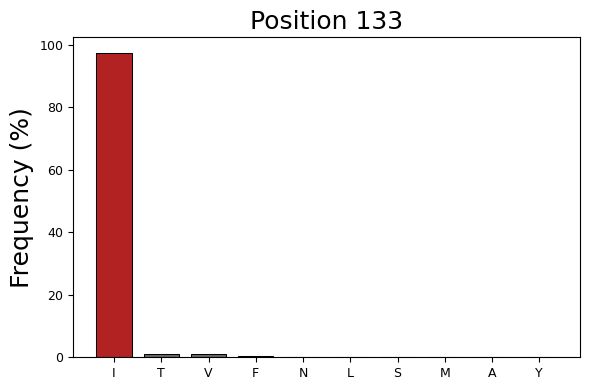

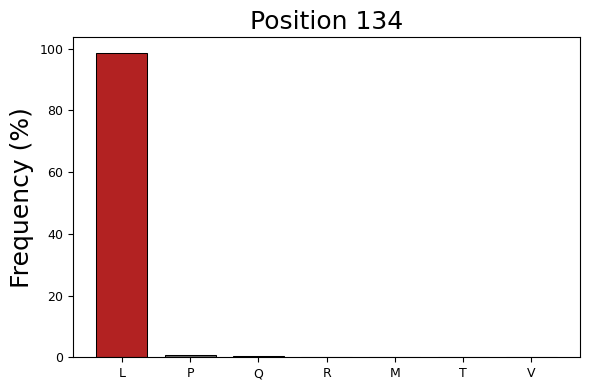

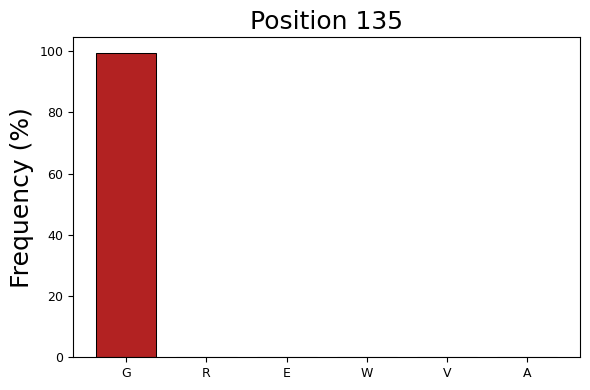

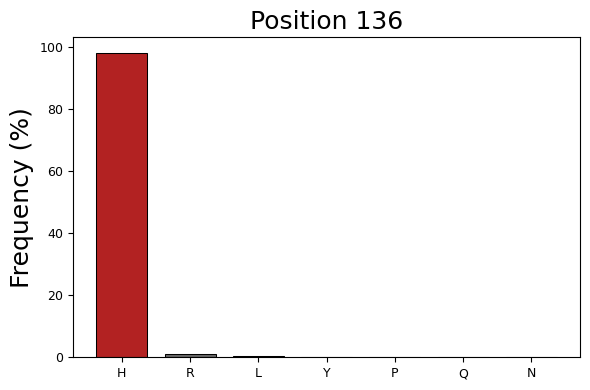

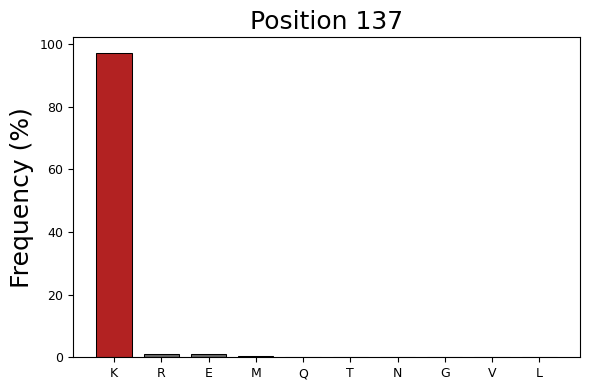

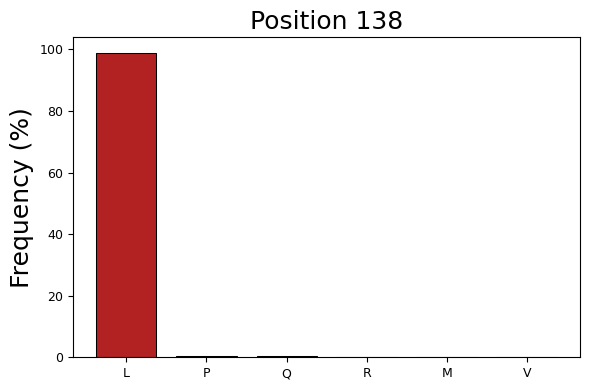

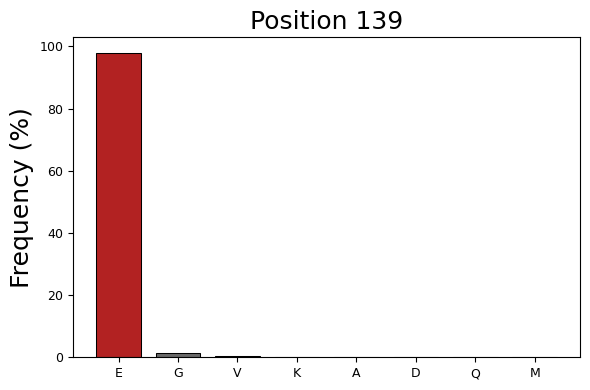

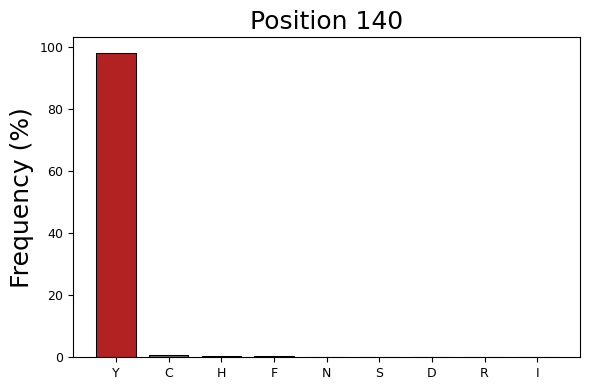

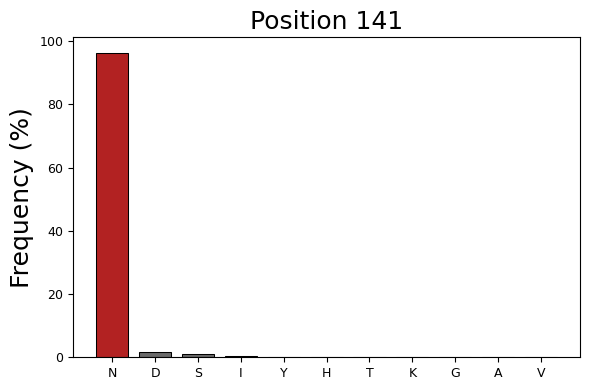

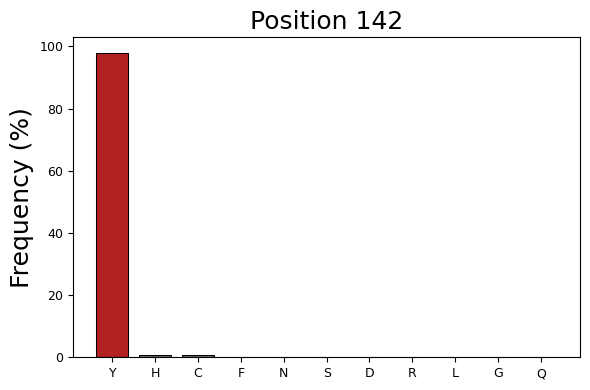

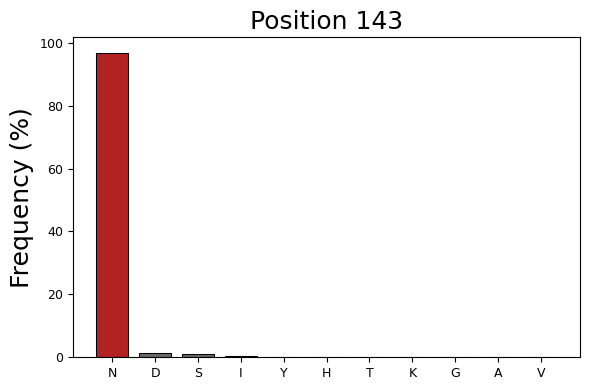

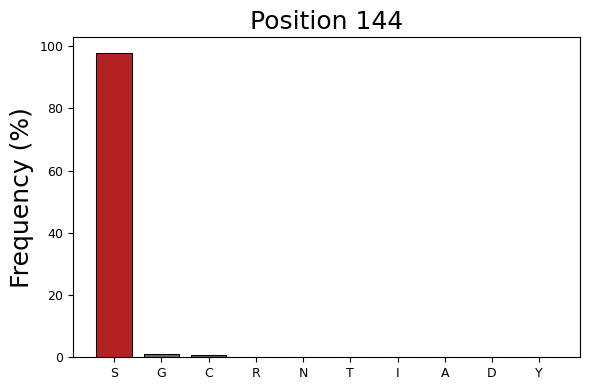

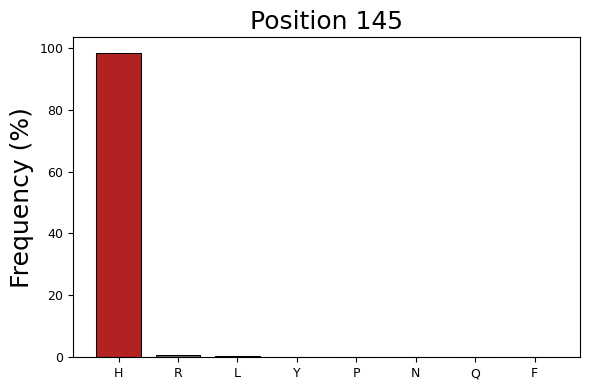

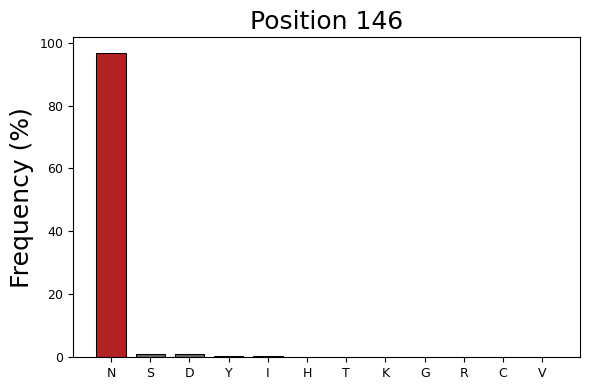

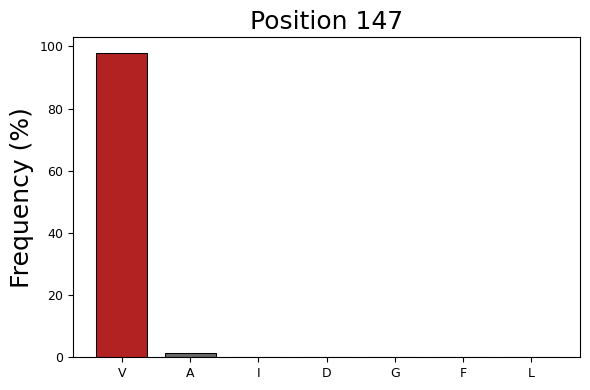

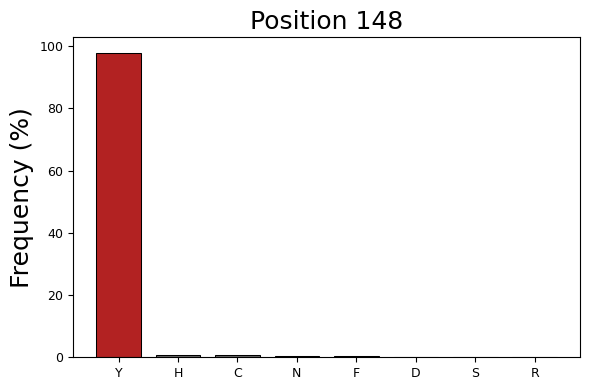

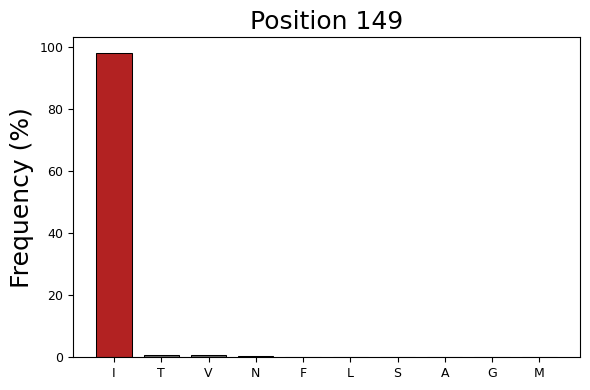

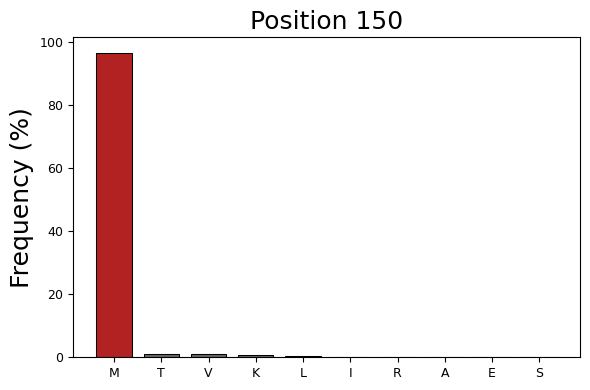

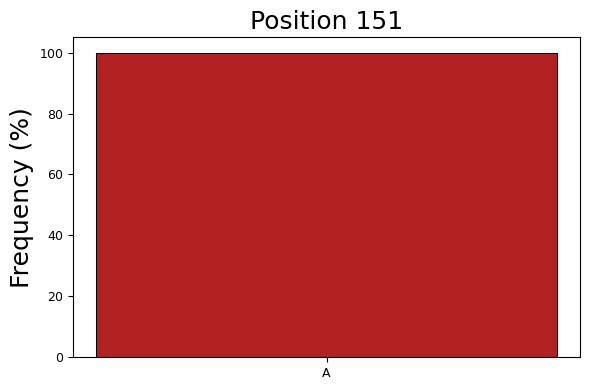

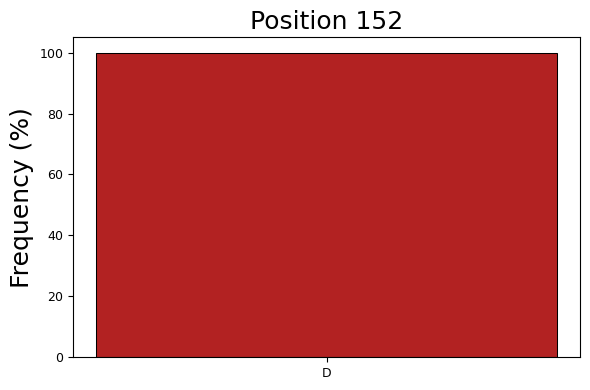

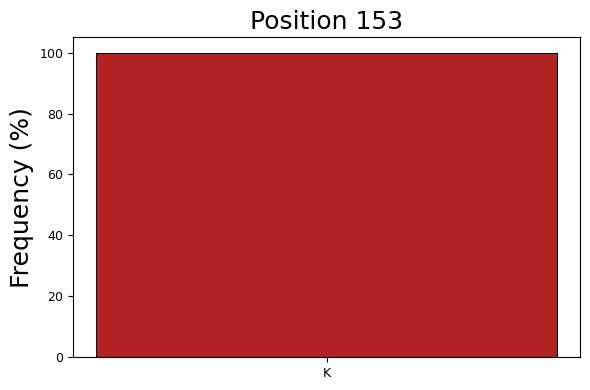

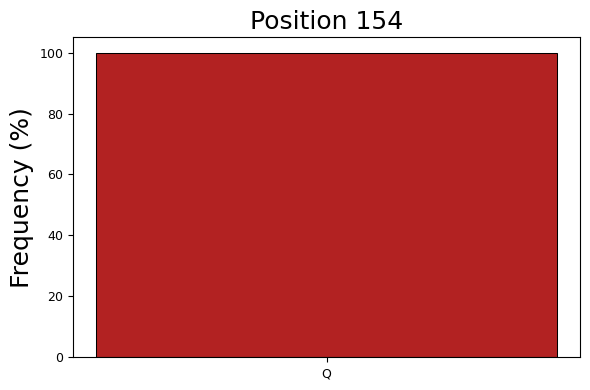

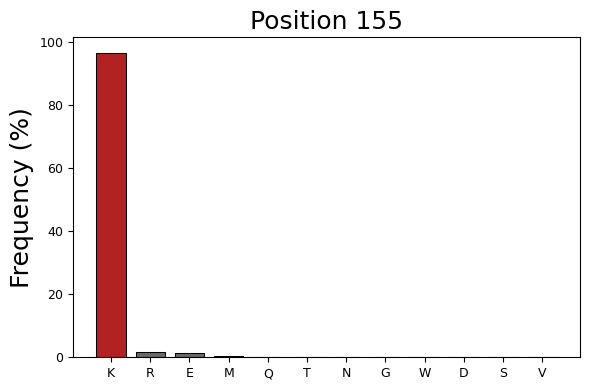

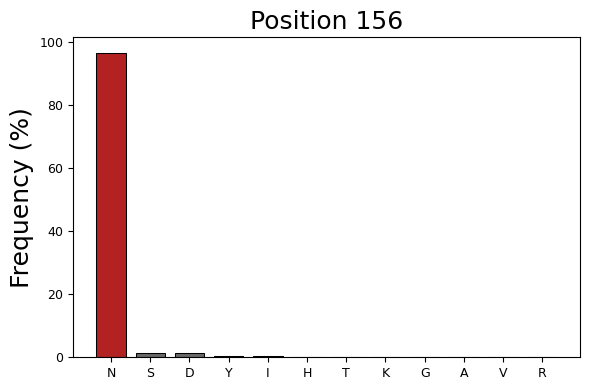

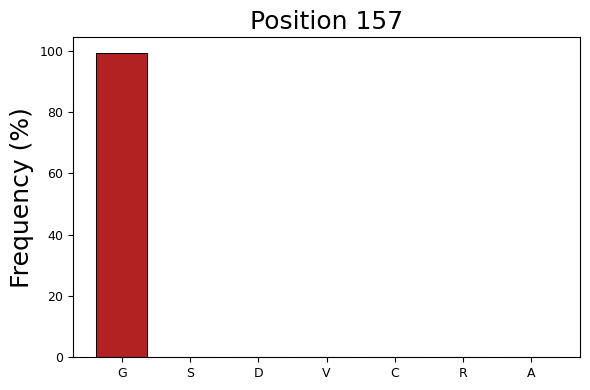

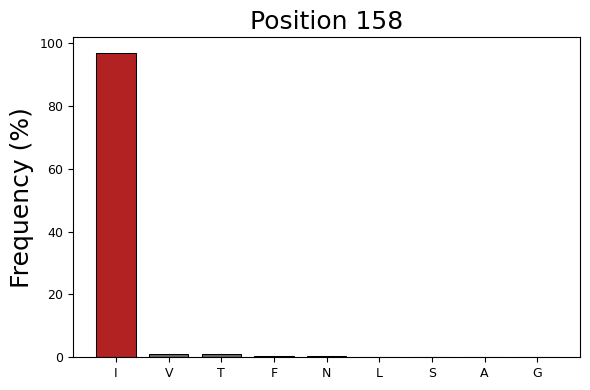

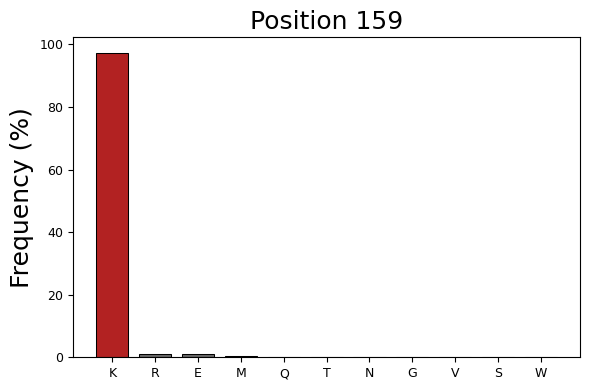

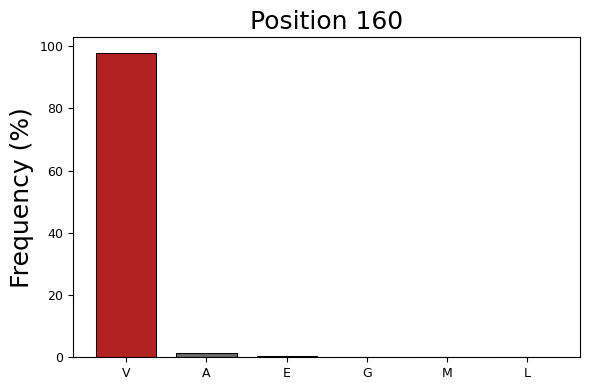

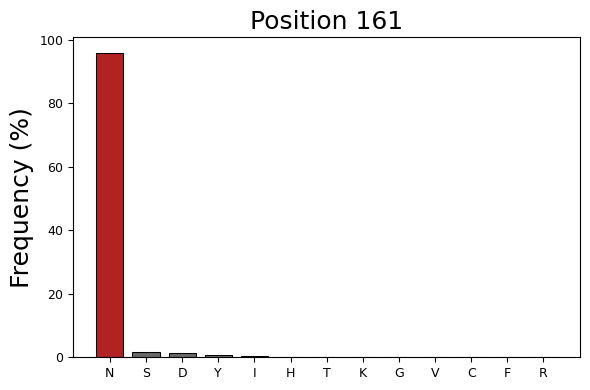

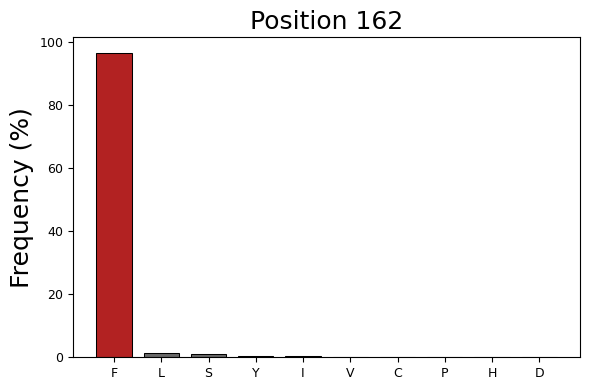

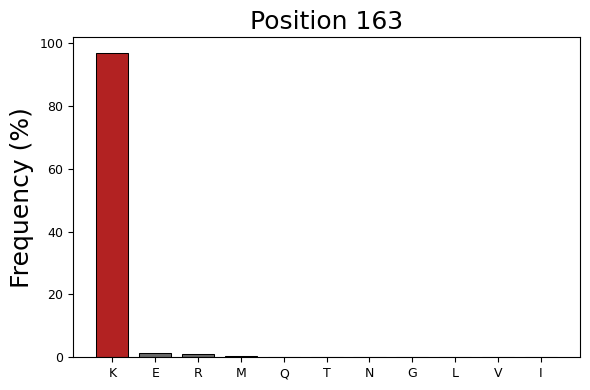

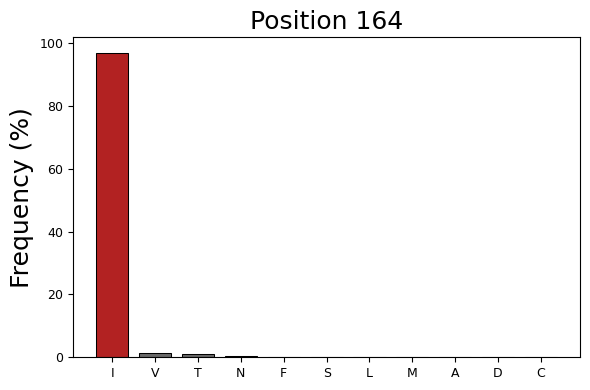

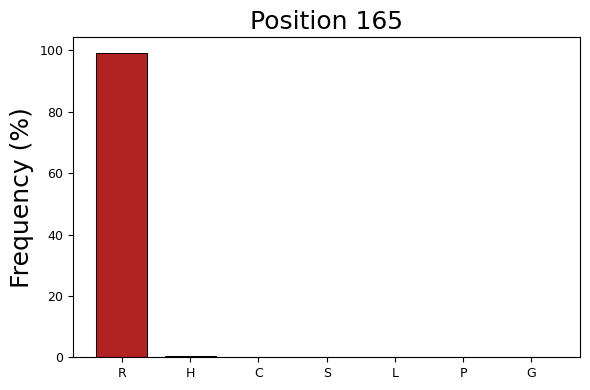

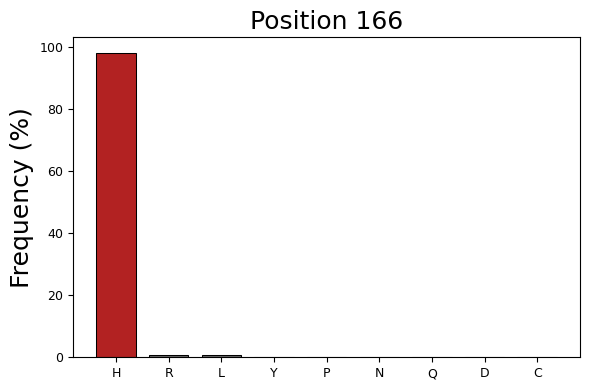

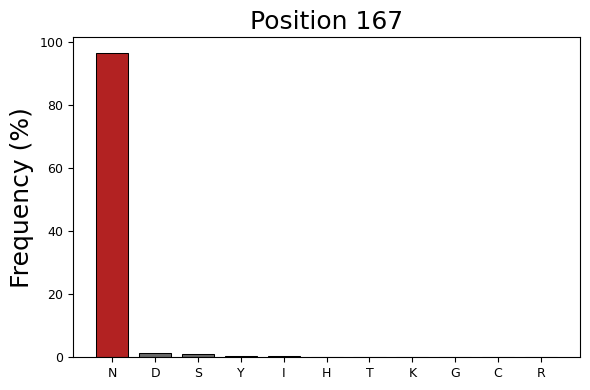

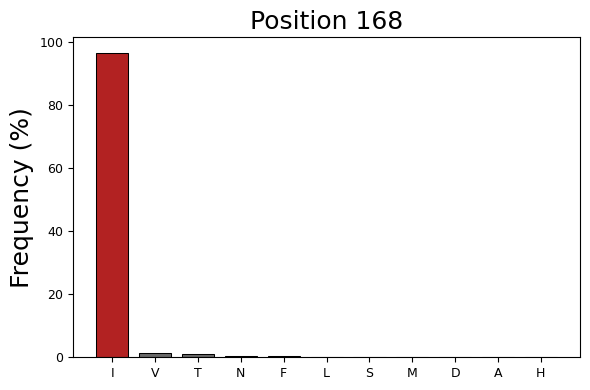

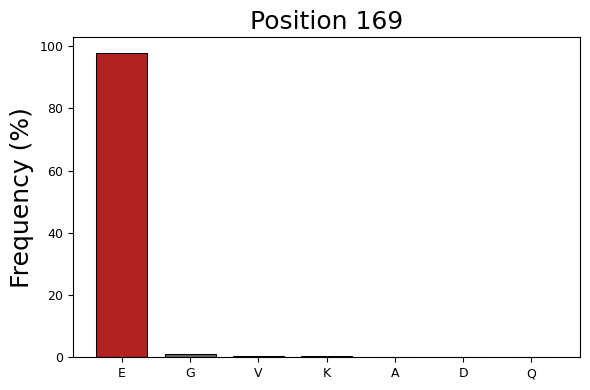

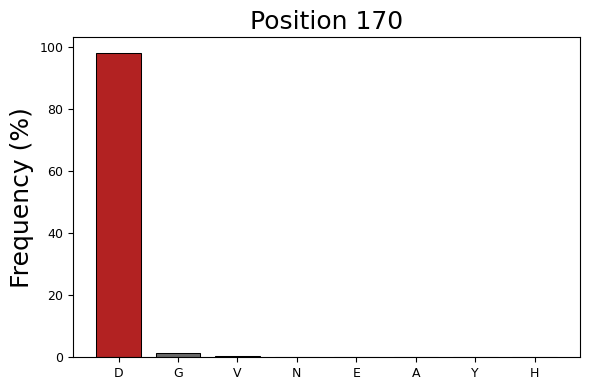

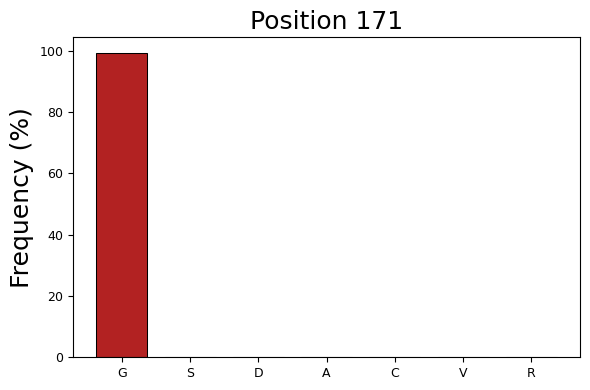

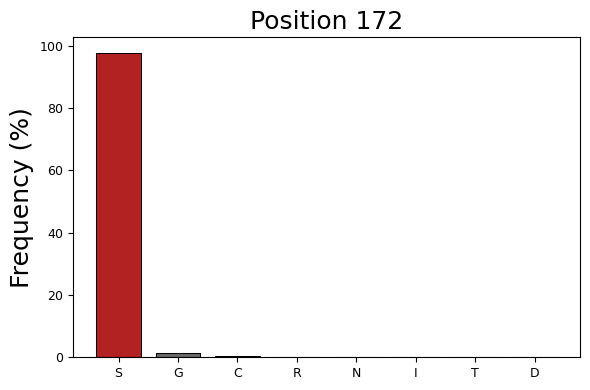

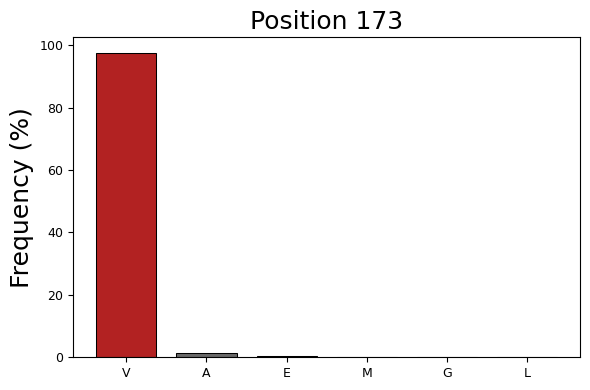

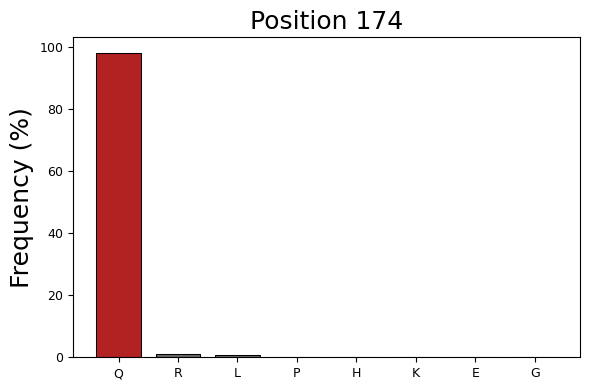

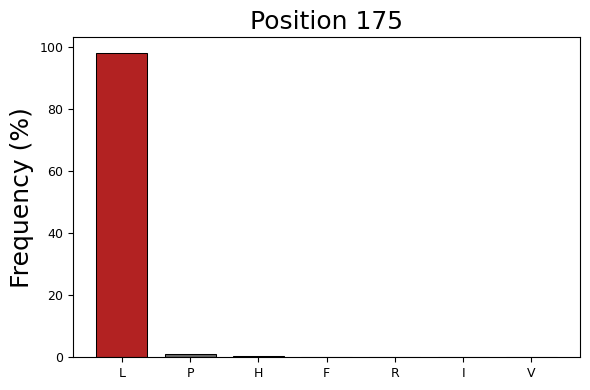

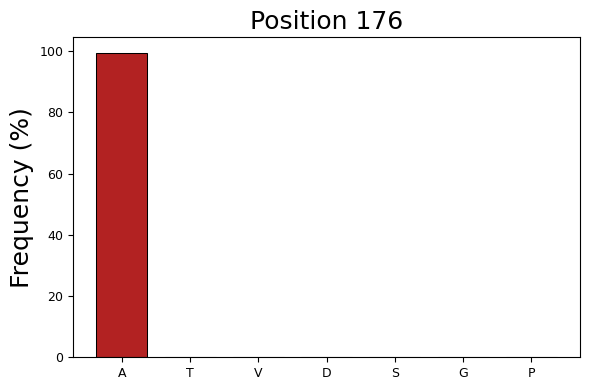

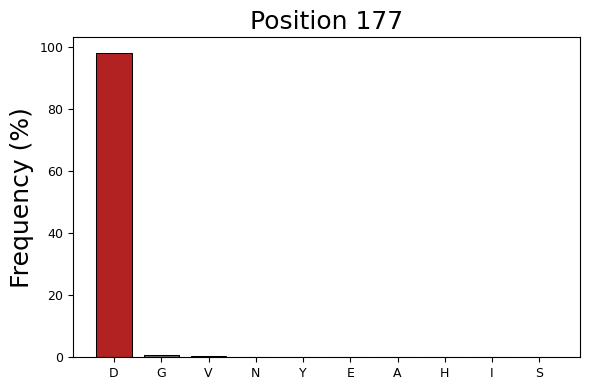

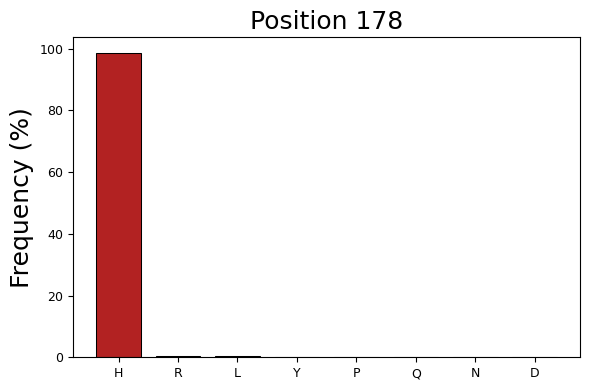

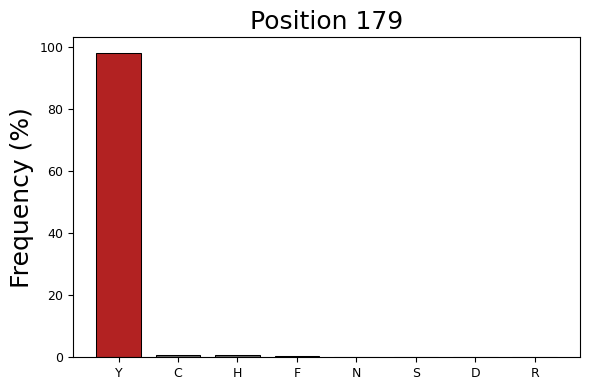

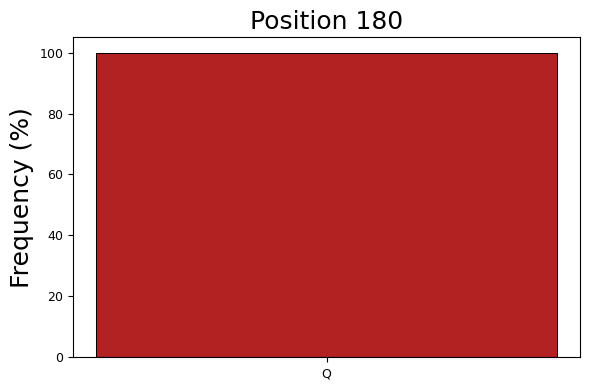

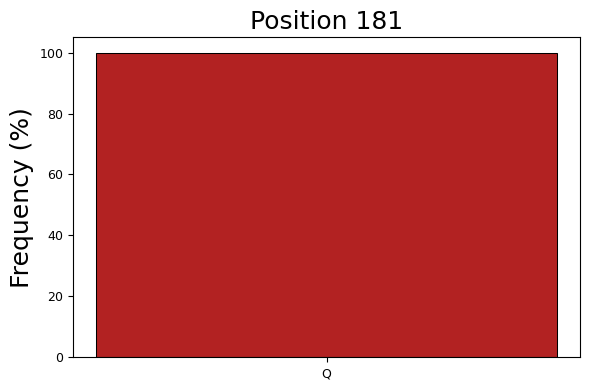

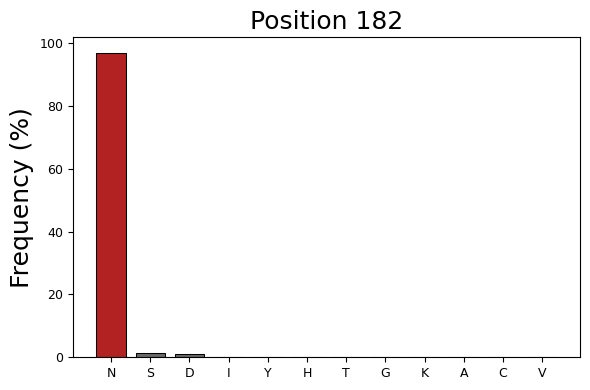

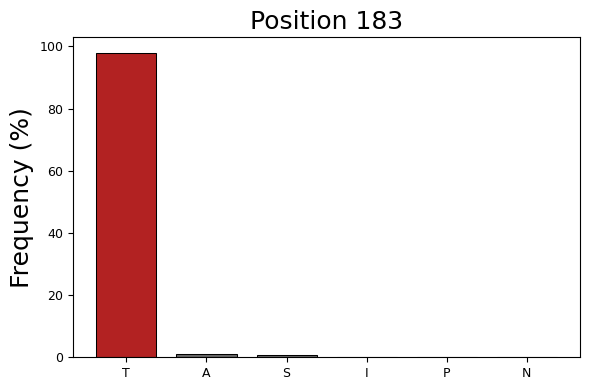

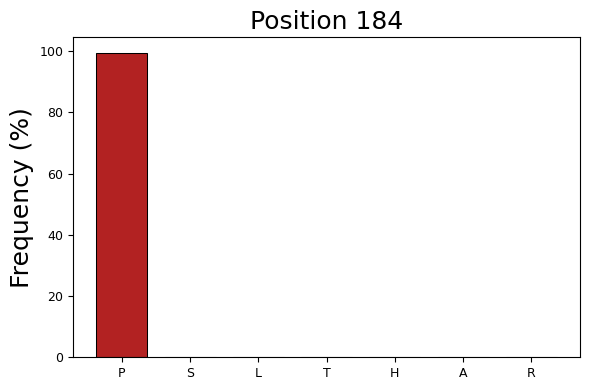

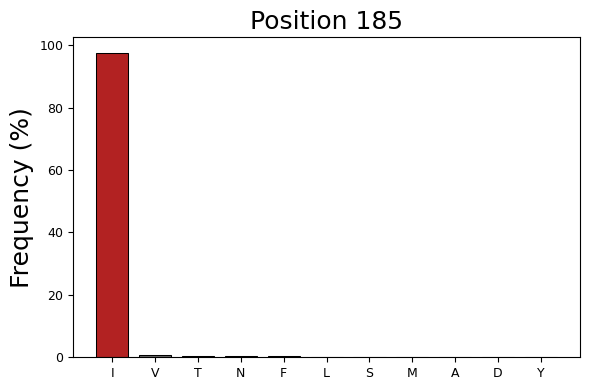

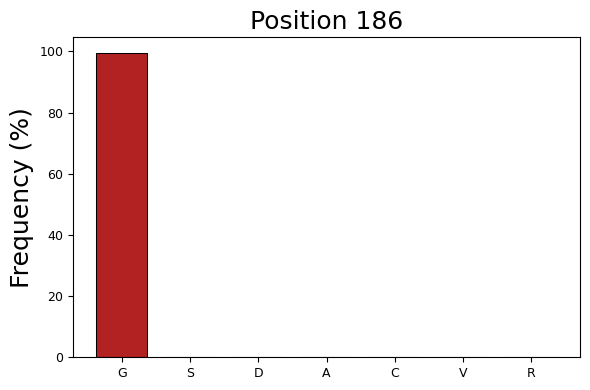

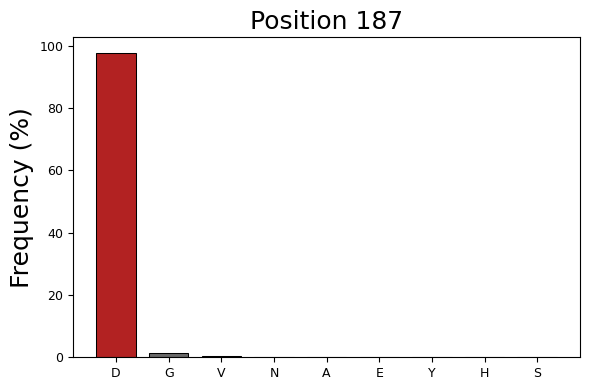

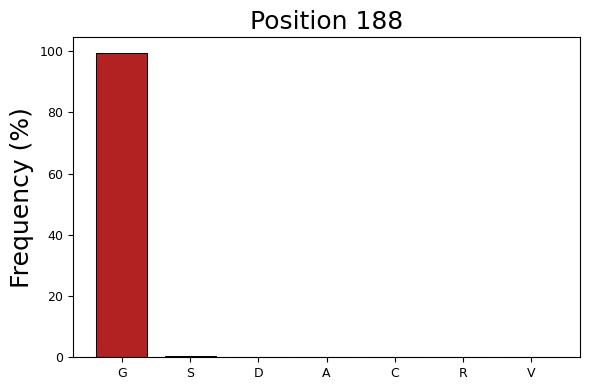

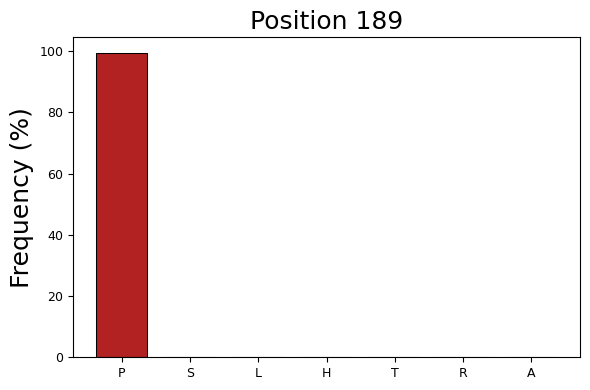

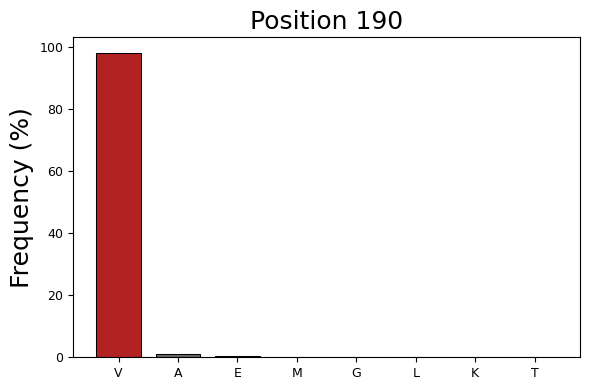

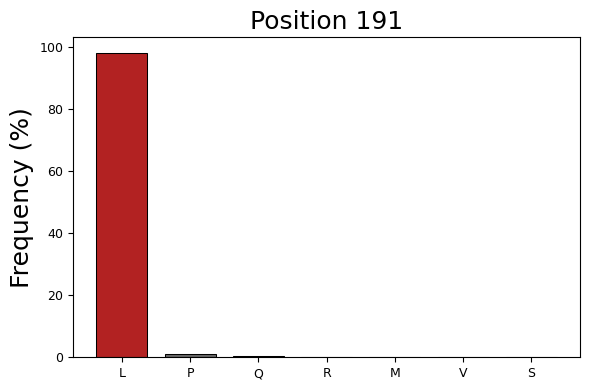

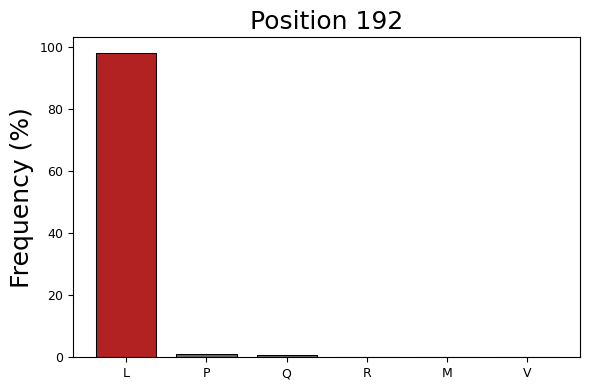

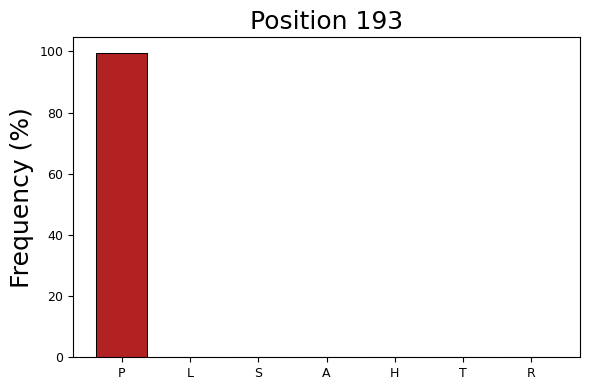

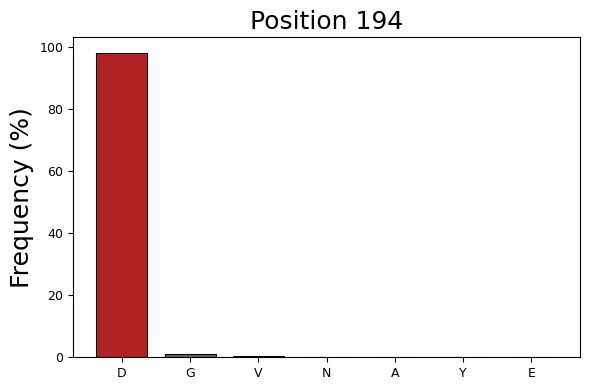

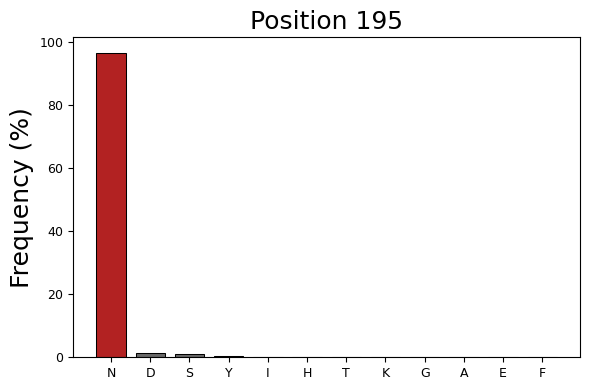

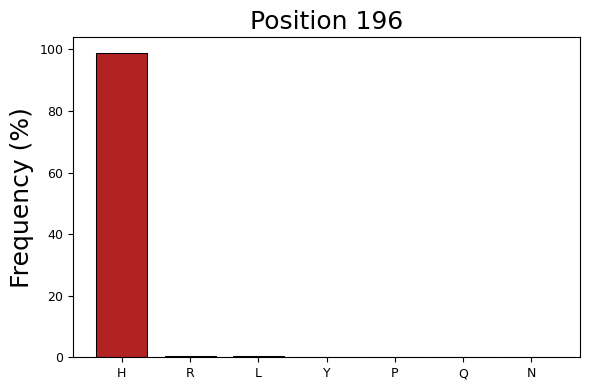

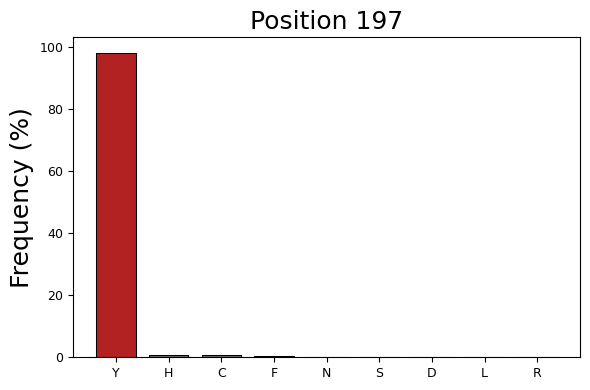

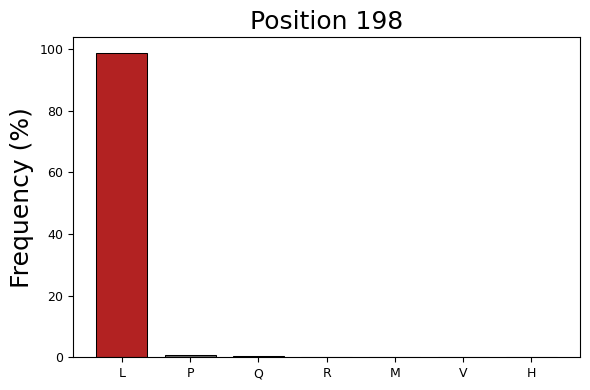

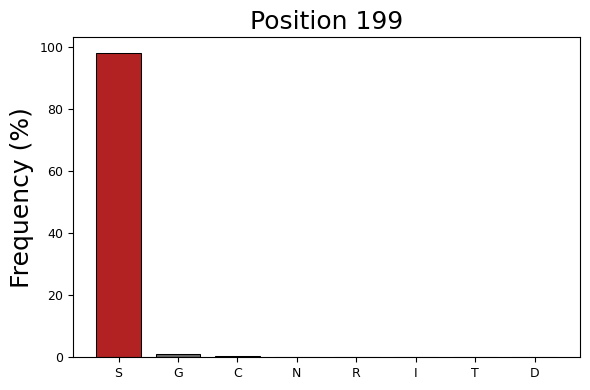

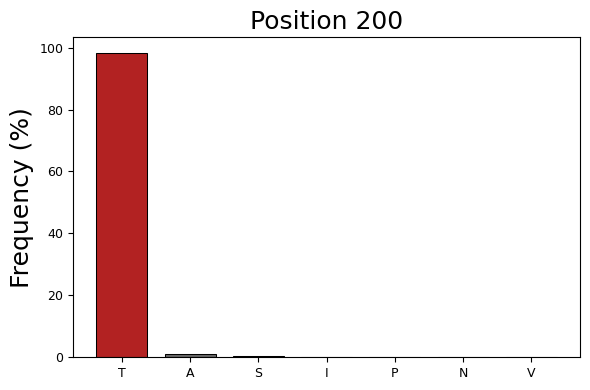

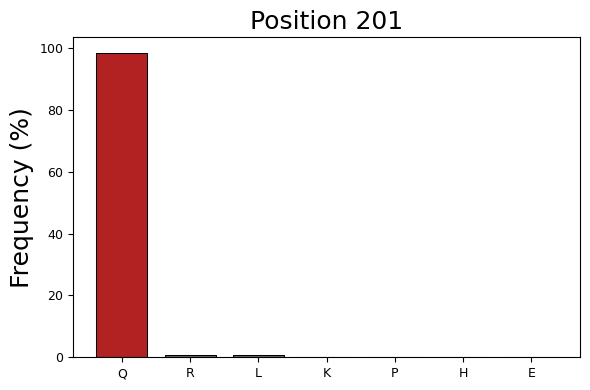

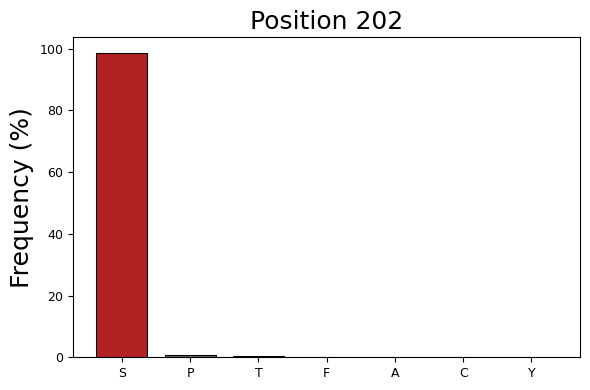

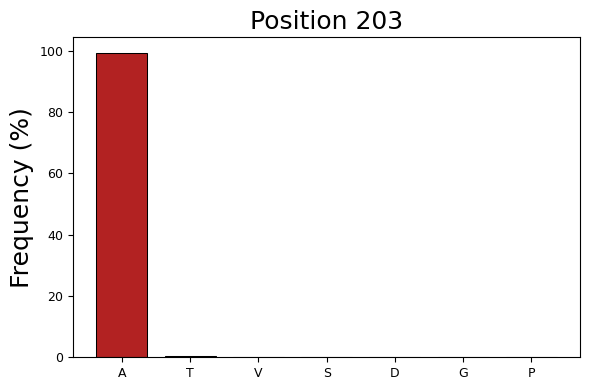

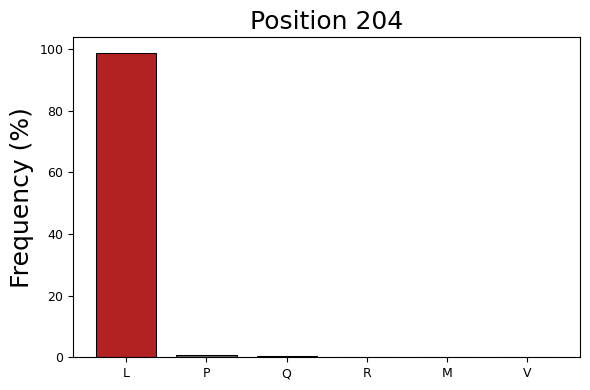

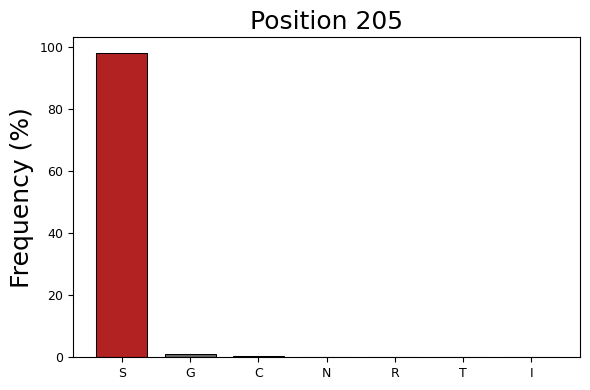

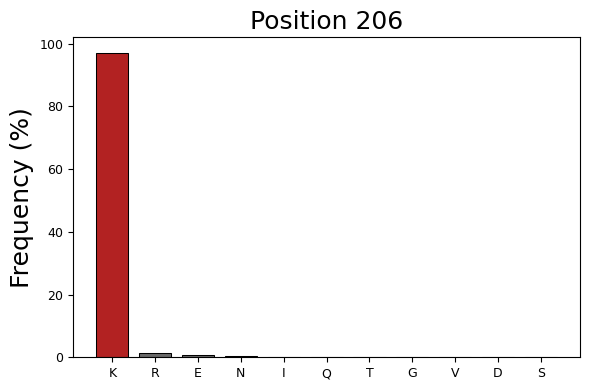

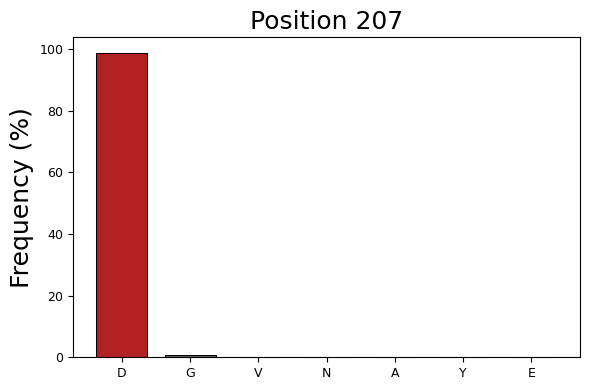

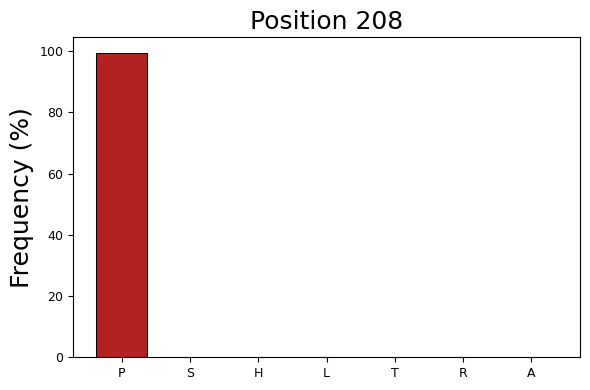

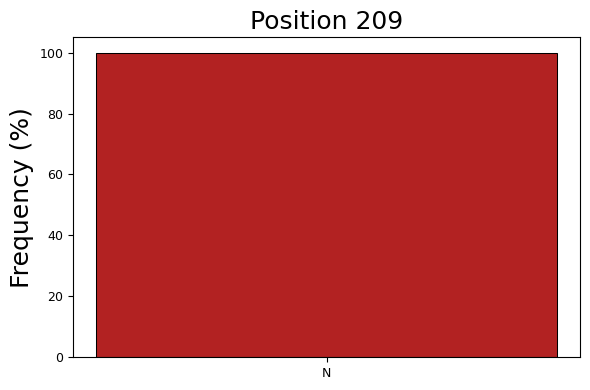

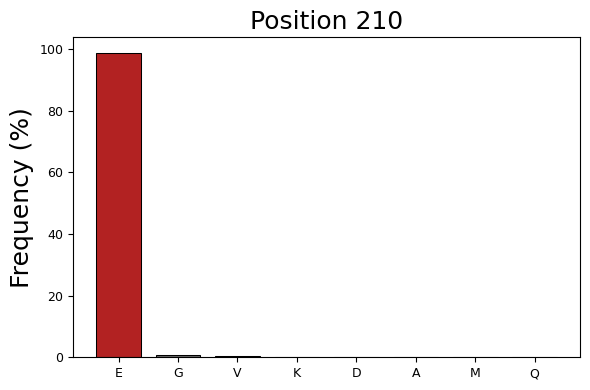

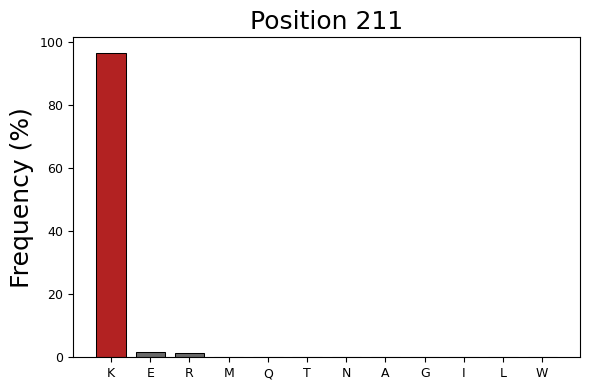

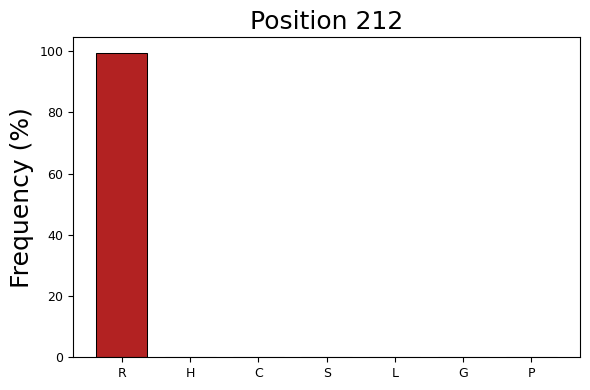

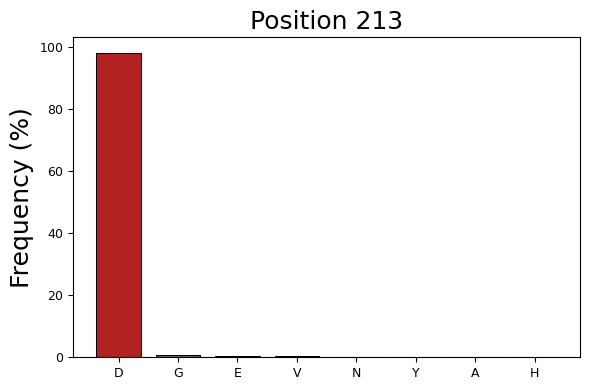

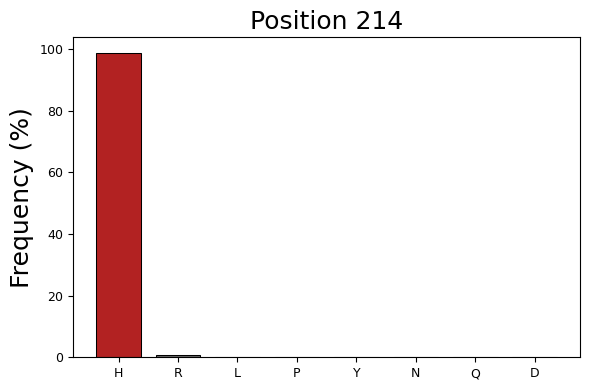

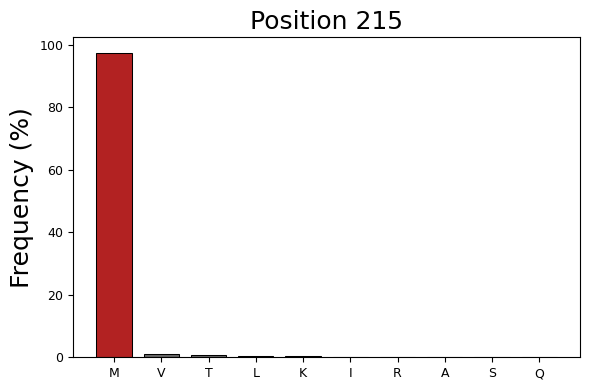

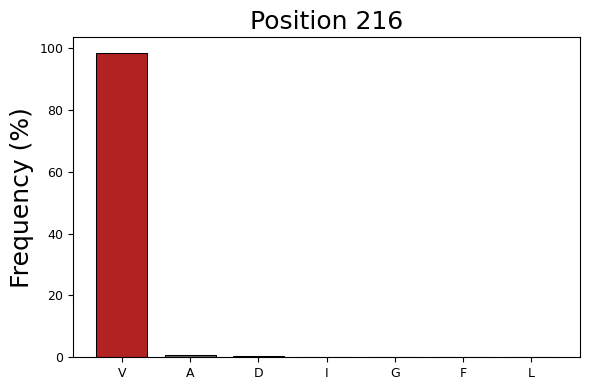

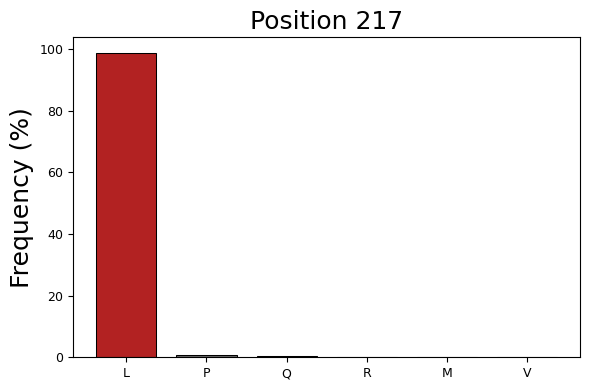

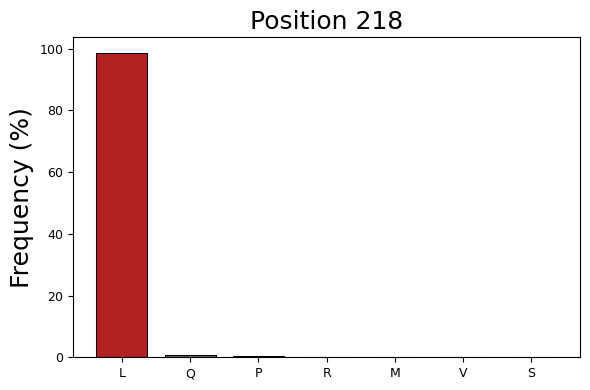

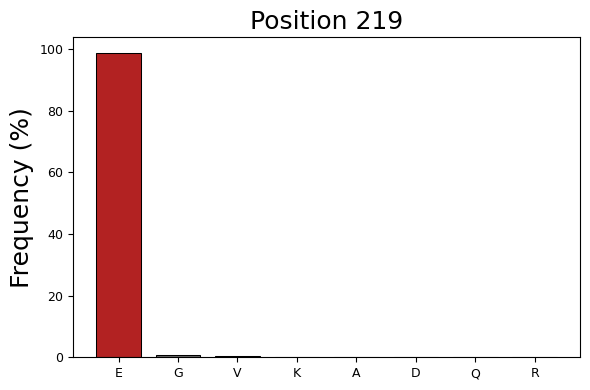

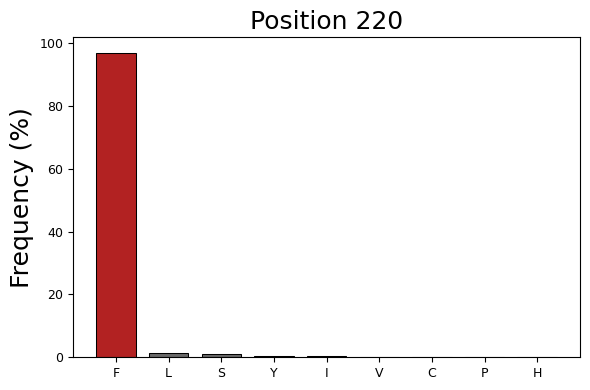

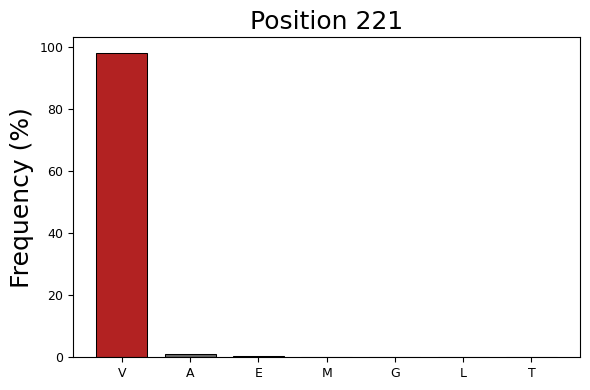

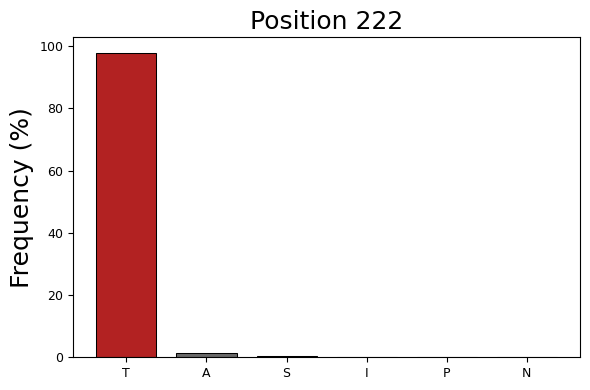

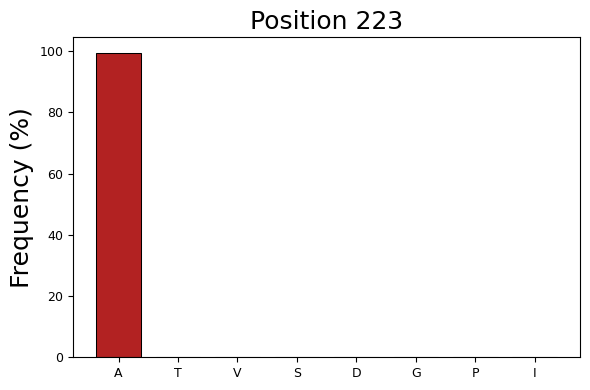

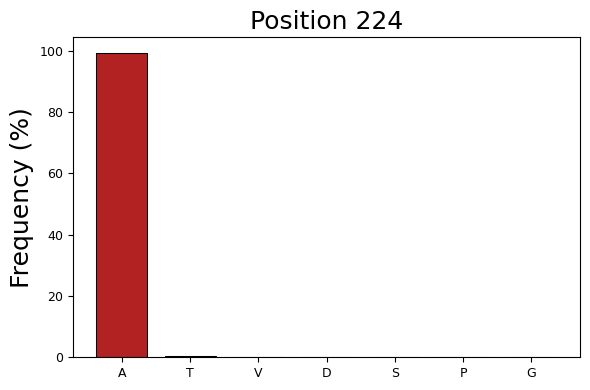

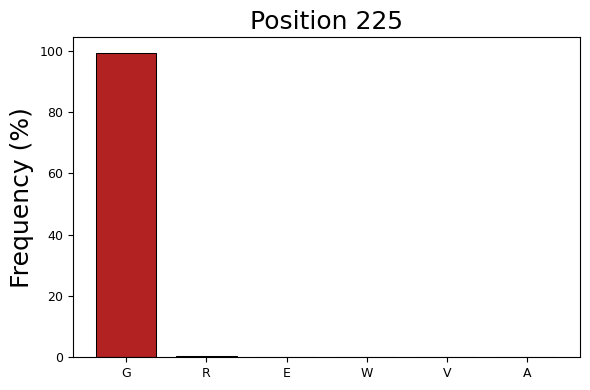

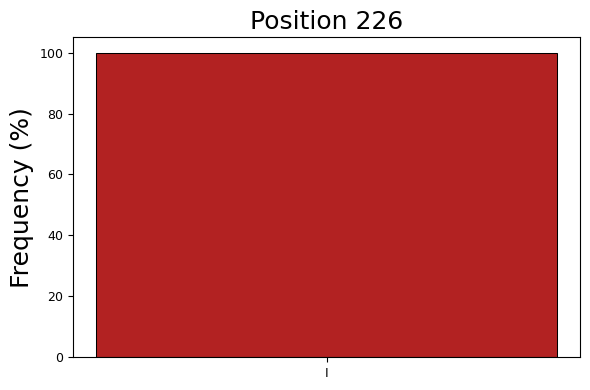

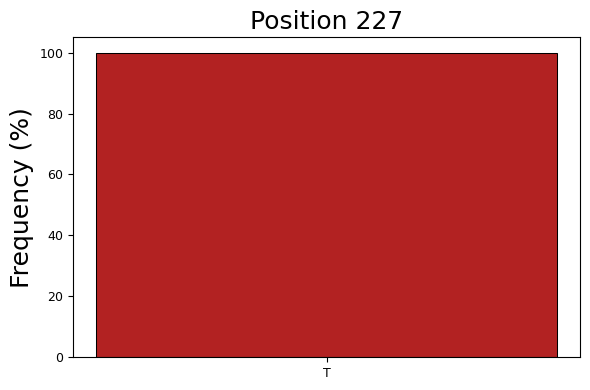

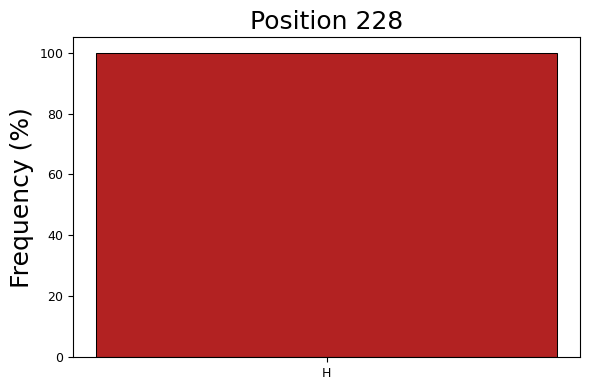

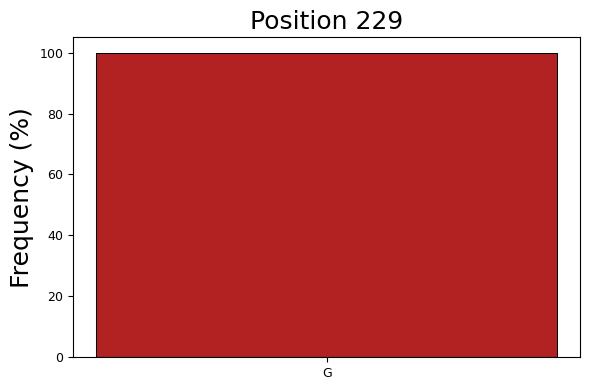

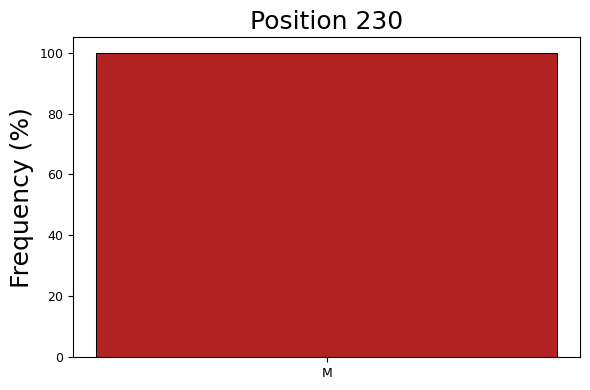

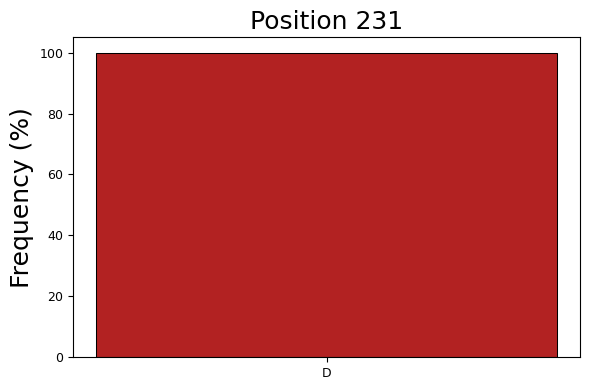

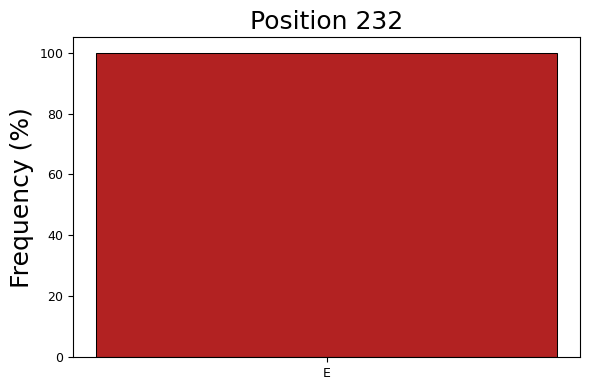

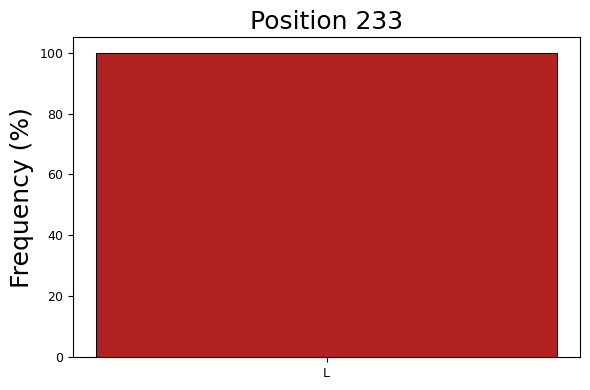

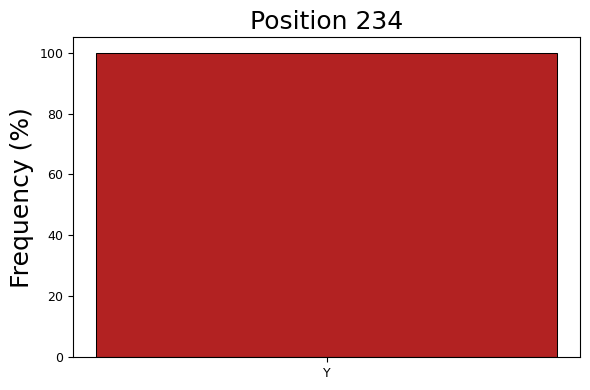

In [30]:
for pos in range(len(wt_seq.seq)):
    canal.plotSiteDistribution(site=pos)